#### Imports


In [3]:
import hnswlib
import numpy as np
import time
from collections import defaultdict
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import psutil
import os
from scipy import stats

     



##### HNSW Inline Filetring Search Trade-offs Analysis

This notebook focuses on the Trade-offs and to ensure an objective comparison between the latency and filter specificity focusing on varying the ef_search or ef in each distribution to generate full recall latency graphs.

##### Trade-offs Found
Higher ef_search:
- Increases search accuracy by considering more candidate nodes 
- Increases search time due to evaluating more nodes

Lower ef_search:
- Speeds up search time
- May decrease accuracy by missing closer nodes due to fewer candidates considered

Source: https://neon.tech/blog/understanding-vector-search-and-hnsw-index-with-pgvector

##### Additional Clarifications

##### ef (search parameter)
- Higher → better recall AND better accuracy, but slower search speed
- Controls search thoroughness at query time

##### ef_construction (build parameter) 
- Higher → better index quality, but slower index building  
- Controls how well-connected the graph is during construction

##### Main difference
- ef_construction affects index building (one-time cost)
- ef affects each search query (runtime cost)


#### Key Components

#### 1. Data Generation & Distribution
- Implements two data distribution scenarios:
  - Uniform distribution (labels equally distributed)
  - Skewed distribution (60%, 30%, 10% label distribution)
  - Skewed distibtion following a power-law distribution using SciPy

### 2. Search Performance Metrics
- **Query Performance**
  - Latency measurements (filtered vs unfiltered)
  - Throughput (queries per second)
  - Memory usage tracking

- **Search Quality**
  - Recall@k calculations
  - Accuracy and precision metrics
  - Filter specificity analysis

### 3. Parameter Analysis
- Comprehensive evaluation across different EF search values
- Investigation of the trade-off between:
  - Search speed
  - Result accuracy
  - Memory consumption

## Key Features

- Dynamic label filtering capability
- Memory usage tracking
- Matched recall points analysis for fair comparisons
- Visualization of results through multiple plots:
  - Recall vs Latency curves
  - Filter Specificity impact
  - EF parameter effects
  - Label-specific comparisons



In [ ]:
    

class LabelFilteredANNEvaluator:
    """
    Design Metrics for Filtered ANN Search:
    1. Query Latency:
       - Measures search time with/without filters
       - Compares overhead of filtering
    2. Accuracy Impact:
       - Recall@k: proportion of true nearest neighbors found
       - How filtering affects quality of results
    3. Filter Friction:
       - Filter specificity: proportion of points passing filter
       - Impact of label distribution on performance
    """
    def __init__(self, dim=16, num_elements=3000):
        self.dim = dim
        self.num_elements = num_elements
        self.metrics = defaultdict(list)

    def generate_uniform_labeled_data(self):
        """Generate uniform data with three labels distributed equally"""
        self.data = np.float32(np.random.random((self.num_elements, self.dim)))
        
        num_per_label = self.num_elements // 3
        self.labels = np.array(['a'] * num_per_label + 
                             ['b'] * num_per_label + 
                             ['c'] * (self.num_elements - 2 * num_per_label))
        p = np.random.permutation(len(self.data))
        self.data = self.data[p]
        self.labels = self.labels[p]
        unique, counts = np.unique(self.labels, return_counts=True)
        self.metrics['label_distribution'] = dict(zip(unique, counts / len(self.labels)))
        return self.data, self.labels
    


    def generate_skewed_labeled_data(self):
        """Generate skewed data with three labels distributed as 60%, 30%, 10%"""
        self.data = np.float32(np.random.random((self.num_elements, self.dim)))
    
        label_a_count = int(self.num_elements * 0.6)  # 60%
        label_b_count = int(self.num_elements * 0.3)  # 30%
        label_c_count = self.num_elements - label_a_count - label_b_count  # Remaining (10%)
    
        self.labels = np.array(['a'] * label_a_count + 
                          ['b'] * label_b_count + 
                          ['c'] * label_c_count)
    
        p = np.random.permutation(len(self.data))
        self.data = self.data[p]
        self.labels = self.labels[p]
    
        unique, counts = np.unique(self.labels, return_counts=True)
        self.metrics['label_distribution'] = dict(zip(unique, counts / len(self.labels)))
    
        return self.data, self.labels

    # def generate_skewed_labeled_data(self):
    #     """Generate skewed data with power-law distribution for more realistic skewness"""
    #     # Generate feature data using power law distribution

    #     self.data = np.zeros((self.num_elements, self.dim), dtype=np.float32)

    #     # Generate each dimension using power law
    #     for d in range(self.dim):
    #     # Use different power law parameters for each dimension
    #         a = 1.5 + d * 0.5  # varying the power law exponent
    #         self.data[:, d] = stats.powerlaw.rvs(a=a, size=self.num_elements)

    #     # Normalize to [0,1] range for consistency with original
    #     self.data = (self.data - self.data.min(axis=0)) / (self.data.max(axis=0) - self.data.min(axis=0))

    #     # Generate label counts using power law
    #     label_probs = stats.powerlaw.rvs(a=2.5, size=3)
    #     label_probs = label_probs / label_probs.sum()  # Normalize to sum to 1

    #     # Calculate counts for each label
    #     label_a_count = int(self.num_elements * label_probs[0])
    #     label_b_count = int(self.num_elements * label_probs[1])
    #     label_c_count = self.num_elements - label_a_count - label_b_count

    #     # Create labels array
    #     self.labels = np.array(['a'] * label_a_count +
    #                         ['b'] * label_b_count +
    #                         ['c'] * label_c_count)

    #     # Shuffle data and labels together
    #     p = np.random.permutation(len(self.data))
    #     self.data = self.data[p]
    #     self.labels = self.labels[p]

    #     # Store distribution metrics as before
    #     unique, counts = np.unique(self.labels, return_counts=True)
    #     self.metrics['label_distribution'] = dict(zip(unique, counts / len(self.labels)))

    #     return self.data, self.labels

    def build_index(self):
        """Build HNSW index with the generated data"""
        self.index = hnswlib.Index(space='cosine', dim=self.dim)
        self.index.init_index(max_elements=self.num_elements, ef_construction=100, M=16)
        self.index.set_ef(20)
        self.index.set_num_threads(1)
        start_time = time.time()
        self.index.add_items(self.data, ids=np.arange(self.num_elements))
        build_time = time.time() - start_time
        self.metrics['build_time'] = build_time

    def create_label_filter(self, target_label):
        """Create filter function for a specific label"""
        def filter_function(idx):
            return self.labels[idx] == target_label
        return filter_function
    
    def calculate_recall(self, filtered_results, true_results, query_points, target_label, k):
        """
    Calculate recall@k for filtered nearest neighbor search results.
    
    Args:
        filtered_results: Results from filtered knn search (n_queries x k)
        true_results: Results from unfiltered knn search (n_queries x k)
        query_points: Query points used for search (n_queries x dim)
        target_label: Label to filter for
        k: Number of nearest neighbors
    
    Returns:
        float: Average recall@k across all queries
        """
        recall = 0
        n_queries = len(query_points)
    
        target_mask = self.labels == target_label
        target_data = self.data[target_mask]
        target_indices = np.where(target_mask)[0]
    
        for i in range(n_queries):
            distances = np.linalg.norm(target_data - query_points[i], axis=1)
            true_neighbor_indices = target_indices[np.argsort(distances)[:k]]
        
            filtered_neighbor_indices = filtered_results[i]
        
            intersection = set(filtered_neighbor_indices) & set(true_neighbor_indices)
            recall += len(intersection) / k
    
        return recall / n_queries


    def calculate_specificity(self, label):
        """Calculate filter specificity using the filter function"""
        filter_func = self.create_label_filter(label)
        points_passing_filter = sum(filter_func(i) for i in range(self.num_elements))
        return points_passing_filter / self.num_elements
    
    def calculate_memory_usage(self):
        """Calculate memory usage of the index and data structures"""
        import psutil
        import os
        
        process = psutil.Process(os.getpid())
        
        # Memory before index operations
        baseline_memory = process.memory_info().rss
        
        # Memory after index operations
        index_memory = self.index.get_max_elements() * self.dim * 4  # 4 bytes per float32
        total_memory = process.memory_info().rss
        
        return {
            'baseline_memory_mb': baseline_memory / (1024 * 1024),
            'index_memory_mb': index_memory / (1024 * 1024),
            'total_memory_mb': total_memory / (1024 * 1024)
        }

    def calculate_accuracy_metrics(self, predicted_indices, true_indices, label):
        """Calculate accuracy and precision"""
        predicted_labels = self.labels[predicted_indices]
        true_labels = self.labels[true_indices]
        
        # Calculate accuracy
        accuracy = np.mean(predicted_labels == true_labels)
        
        # Calculate precision for specific label
        true_positives = np.sum((predicted_labels == label) & (true_labels == label))
        false_positives = np.sum((predicted_labels == label) & (true_labels != label))
        precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
        
        return {
            'accuracy': accuracy,
            'precision': precision
        }

    def calculate_throughput(self, query_time, num_queries):
        """Calculate queries per second throughput"""
        return num_queries / query_time if query_time > 0 else 0

    def match_recall_points(self, results, recall_thresholds=[0.5, 0.6, 0.7, 0.8, 0.9]):
        """Find points with matching recall levels for fair comparison"""
        matched_points = defaultdict(lambda: defaultdict(dict))
        
        for dist_name in results:
            for label in ['a', 'b', 'c']:
                recalls = results[dist_name][f'{label}_recall']
                latencies = results[dist_name][f'{label}_latency']
                
                # Find closest points to each recall threshold
                for threshold in recall_thresholds:
                    closest_idx = min(range(len(recalls)), 
                                    key=lambda i: abs(recalls[i] - threshold))
                    matched_points[dist_name][label][threshold] = {
                        'recall': recalls[closest_idx],
                        'latency': latencies[closest_idx],
                        'ef': results[dist_name]['ef'][closest_idx]
                    }
        
        return matched_points
    
    def evaluate_comprehensive(self, ef_values=None, num_queries=100, k=10):
        """Comprehensive evaluation across different EF values and distributions"""
        if ef_values is None:
            ef_values = [10, 20, 50, 100, 200]
                
        distributions = {
            'uniform': self.generate_uniform_labeled_data,
            'skewed': self.generate_skewed_labeled_data
        }
        
        results = defaultdict(lambda: defaultdict(list))
        
        for dist_name, dist_func in distributions.items():
            print(f"\nEvaluating {dist_name} distribution...")
            
            # Generate data and build index
            dist_func()
            self.build_index()
            
            # Measure memory usage
            memory_metrics = self.calculate_memory_usage()
            results[dist_name]['memory_metrics'] = memory_metrics
            
            # Calculate and store filter specificities
            filter_specificity = {}
            for label in ['a', 'b', 'c']:
                filter_func = self.create_label_filter(label)
                points_passing_filter = sum(filter_func(i) for i in range(self.num_elements))
                filter_specificity[label] = points_passing_filter / self.num_elements
                results[dist_name][f'specificity_{label}'] = filter_specificity[label]
            
            query_points = np.float32(np.random.random((num_queries, self.dim)))
            
            for ef in ef_values:
                print(f"Processing EF={ef}...")
                self.index.set_ef(ef)
                
                # Unfiltered baseline
                start_time = time.time()
                unfiltered_labels, _ = self.index.knn_query(query_points, k=k)
                unfiltered_time = time.time() - start_time
                
                # Calculate unfiltered throughput
                throughput = self.calculate_throughput(unfiltered_time, num_queries)
                
                results[dist_name]['ef'].append(ef)
                results[dist_name]['unfiltered_latency'].append(unfiltered_time / num_queries)
                results[dist_name]['unfiltered_recall'].append(1.0)
                results[dist_name]['unfiltered_throughput'].append(throughput)
                
                # Per-label evaluation
                for label in ['a', 'b', 'c']:
                    filter_func = self.create_label_filter(label)
                    
                    # Measure filtered search performance
                    start_time = time.time()
                    filtered_labels, _ = self.index.knn_query(query_points, k=k, filter=filter_func)
                    filtered_time = time.time() - start_time
                    
                    # Calculate metrics
                    recall = self.calculate_recall(filtered_labels, unfiltered_labels, query_points, label, k)
                    accuracy_metrics = self.calculate_accuracy_metrics(filtered_labels.flatten(), 
                                                                unfiltered_labels.flatten(), 
                                                                label)
                    throughput = self.calculate_throughput(filtered_time, num_queries)
                    
                    # Store metrics
                    results[dist_name][f'{label}_latency'].append(filtered_time / num_queries)
                    results[dist_name][f'{label}_recall'].append(recall)
                    results[dist_name][f'{label}_specificity'].append(filter_specificity[label])
                    results[dist_name][f'{label}_throughput'].append(throughput)
                    results[dist_name][f'{label}_accuracy'].append(accuracy_metrics['accuracy'])
                    results[dist_name][f'{label}_precision'].append(accuracy_metrics['precision'])

        matched_points = self.match_recall_points(results)
        results['matched_points'] = matched_points
        return results

In [36]:
def plot_comprehensive_results(results):
    """Plot comprehensive comparison graphs"""
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 15))
    
    colors = {'a': 'blue', 'b': 'green', 'c': 'red', 'unfiltered': 'black'}
    markers = {'uniform': 'o', 'skewed': 's'}
    
    # Get only distribution names (exclude matched_points)
    dist_names = [name for name in results.keys() if name in ['uniform', 'skewed']]
    
    # Plot 1: Recall-Latency curves
    for dist_name in dist_names:
        # Unfiltered baseline
        ax1.plot(results[dist_name]['unfiltered_latency'],
                results[dist_name]['unfiltered_recall'],
                color=colors['unfiltered'],
                marker=markers[dist_name],
                linestyle='-' if dist_name == 'uniform' else '--',
                label=f'Unfiltered ({dist_name})')
        
        # Per-label curves
        for label in ['a', 'b', 'c']:
            ax1.plot(results[dist_name][f'{label}_latency'],
                    results[dist_name][f'{label}_recall'],
                    color=colors[label],
                    marker=markers[dist_name],
                    linestyle='-' if dist_name == 'uniform' else '--',
                    label=f'Label {label} ({dist_name})')
    
    ax1.set_title('Recall vs Latency')
    ax1.set_xlabel('Latency (s)')
    ax1.set_ylabel('Recall')
    ax1.grid(True)
    ax1.legend()
    
    # Plot 2: Specificity-Latency relationship
    for dist_name in dist_names:
        for label in ['a', 'b', 'c']:
            specificities = [results[dist_name][f'specificity_{label}']] * len(results[dist_name][f'{label}_latency'])
            latencies = results[dist_name][f'{label}_latency']
            ax2.scatter(specificities,
                       latencies,
                       color=colors[label],
                       marker=markers[dist_name],
                       label=f'Label {label} ({dist_name})')
    
    ax2.set_title('Latency vs Filter Specificity')
    ax2.set_xlabel('Filter Specificity (proportion of points passing filter)')
    ax2.set_ylabel('Latency (s)')
    ax2.grid(True)
    ax2.legend()
    
    # Plot 3: EF impact on recall
    for dist_name in dist_names:
        ef_values = results[dist_name]['ef']
        for label in ['a', 'b', 'c']:
            ax3.plot(ef_values,
                    results[dist_name][f'{label}_recall'],
                    color=colors[label],
                    marker=markers[dist_name],
                    linestyle='-' if dist_name == 'uniform' else '--',
                    label=f'Label {label} ({dist_name})')
    
    ax3.set_title('Recall vs EF')
    ax3.set_xlabel('EF Value')
    ax3.set_ylabel('Recall')
    ax3.grid(True)
    ax3.legend()
    
    # Plot 4: EF impact on latency
    for dist_name in dist_names:
        ef_values = results[dist_name]['ef']
        for label in ['a', 'b', 'c']:
            ax4.plot(ef_values,
                    results[dist_name][f'{label}_latency'],
                    color=colors[label],
                    marker=markers[dist_name],
                    linestyle='-' if dist_name == 'uniform' else '--',
                    label=f'Label {label} ({dist_name})')
    
    ax4.set_title('Latency vs EF')
    ax4.set_xlabel('EF Value')
    ax4.set_ylabel('Latency (s)')
    ax4.grid(True)
    ax4.legend()
    
    plt.tight_layout()
    return fig

def plot_label_specific_comparisons(results):
    """Create separate plots for each label comparing uniform vs skewed distributions"""
    dist_names = [name for name in results.keys() if name in ['uniform', 'skewed']]
    
    # Create figure for specificity comparisons
    fig1, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 5))
    
    # Create figure for recall-latency comparisons
    fig2, (ax4, ax5, ax6) = plt.subplots(1, 3, figsize=(20, 5))
    
    colors = {'uniform': 'blue', 'skewed': 'red'}
    markers = {'uniform': 'o', 'skewed': 's'}
    
    # Plot specificity comparisons for each label
    for idx, label in enumerate(['a', 'b', 'c']):
        ax = [ax1, ax2, ax3][idx]
        
        for dist_name in dist_names:
            specificities = [results[dist_name][f'specificity_{label}']] * len(results[dist_name][f'{label}_latency'])
            latencies = results[dist_name][f'{label}_latency']
            ax.scatter(specificities,
                      latencies,
                      color=colors[dist_name],
                      marker=markers[dist_name],
                      label=f'{dist_name.capitalize()} Distribution',
                      s=100)
        
        ax.set_title(f'Label {label}: Latency vs Filter Specificity')
        ax.set_xlabel('Filter Specificity')
        ax.set_ylabel('Latency (s)')
        ax.grid(True)
        ax.legend()
    
    # Plot recall-latency comparisons for each label
    for idx, label in enumerate(['a', 'b', 'c']):
        ax = [ax4, ax5, ax6][idx]
        
        for dist_name in dist_names:
            ax.plot(results[dist_name][f'{label}_latency'],
                   results[dist_name][f'{label}_recall'],
                   color=colors[dist_name],
                   marker=markers[dist_name],
                   label=f'{dist_name.capitalize()} Distribution',
                   linewidth=2,
                   markersize=8)
        
        ax.set_title(f'Label {label}: Recall vs Latency')
        ax.set_xlabel('Latency (s)')
        ax.set_ylabel('Recall')
        ax.grid(True)
        ax.legend()
    
    fig1.suptitle('Per-Label Filter Specificity Impact Analysis', fontsize=16, y=1.05)
    fig2.suptitle('Per-Label Recall-Latency Analysis', fontsize=16, y=1.05)
    
    plt.tight_layout()
    return fig1, fig2

Running comprehensive evaluation...

Evaluating uniform distribution...
Processing EF=10...
Processing EF=20...
Processing EF=50...
Processing EF=100...
Processing EF=200...

Evaluating skewed distribution...
Processing EF=10...
Processing EF=20...
Processing EF=50...
Processing EF=100...
Processing EF=200...

Generating comparison plots...


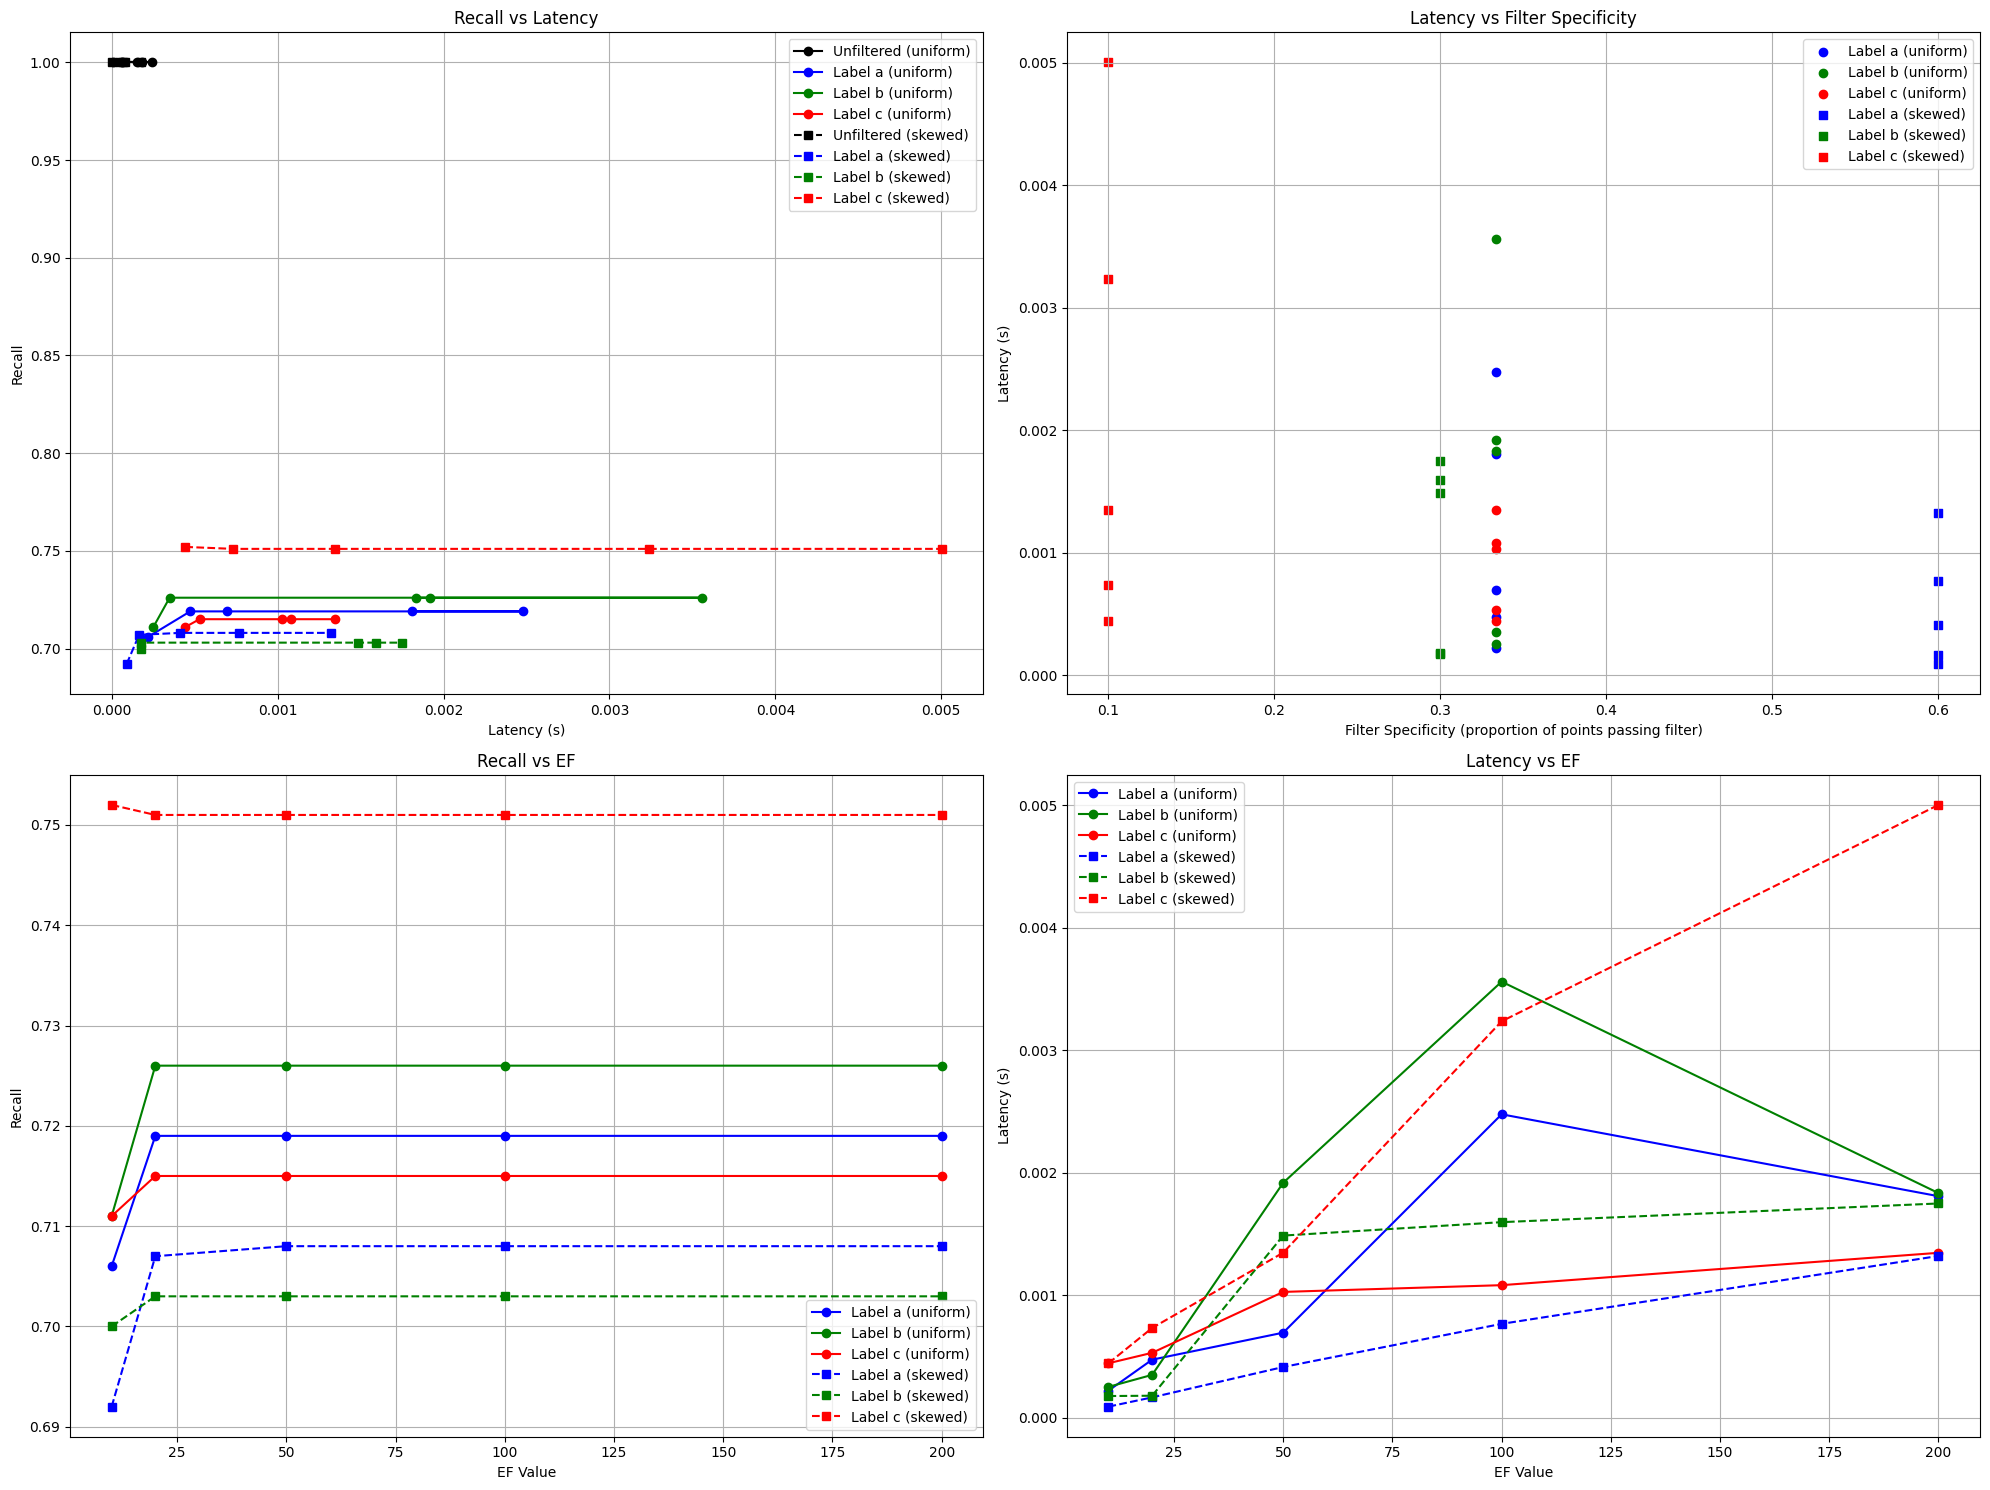

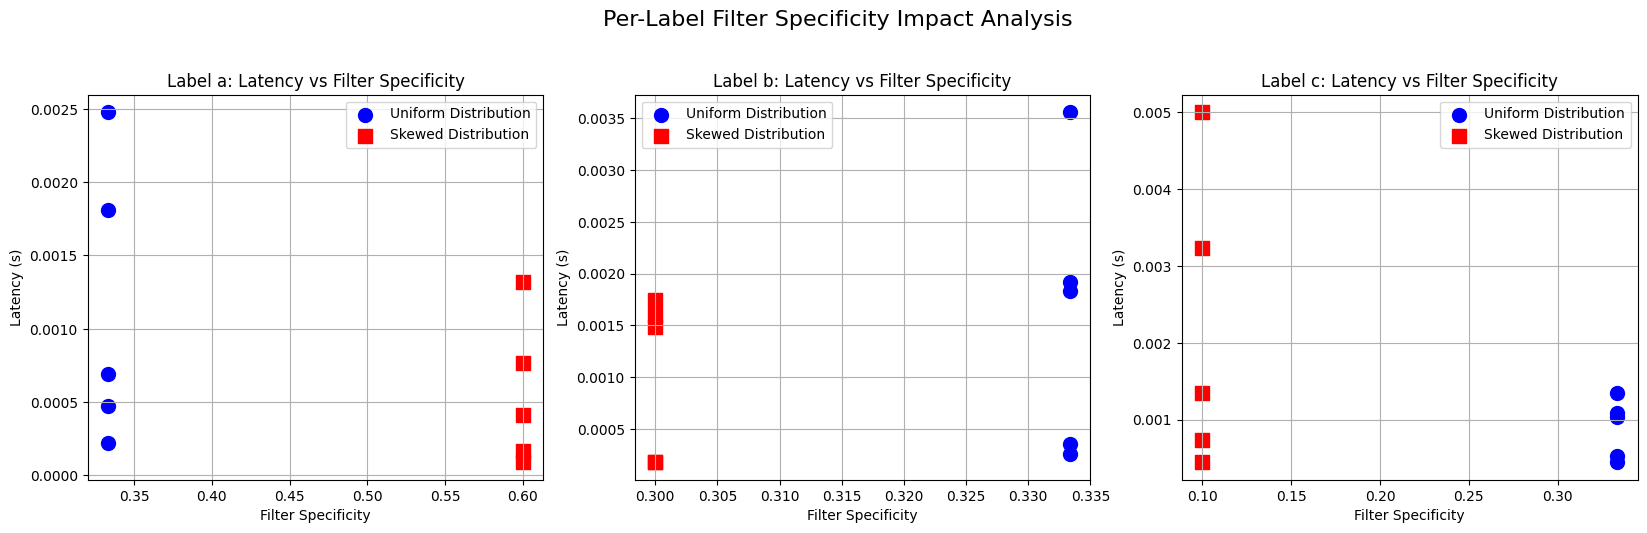

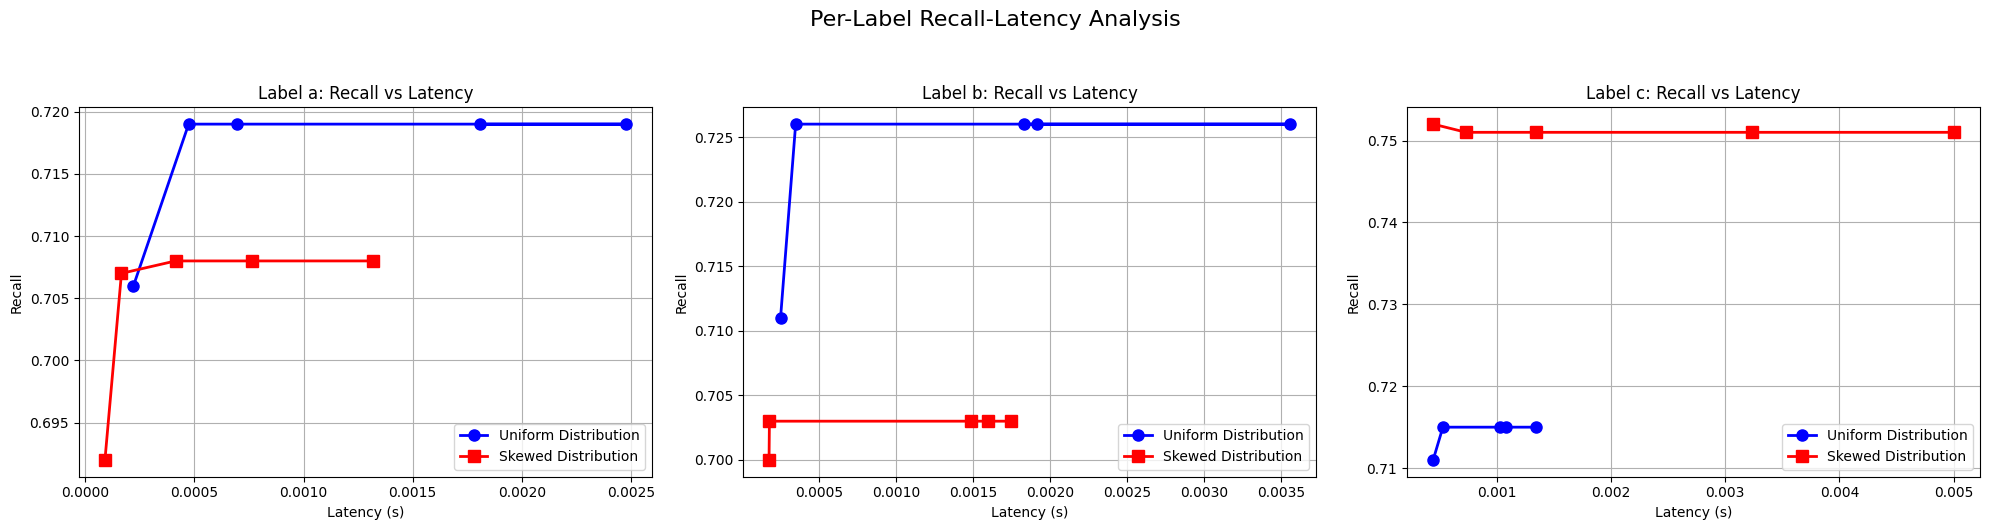

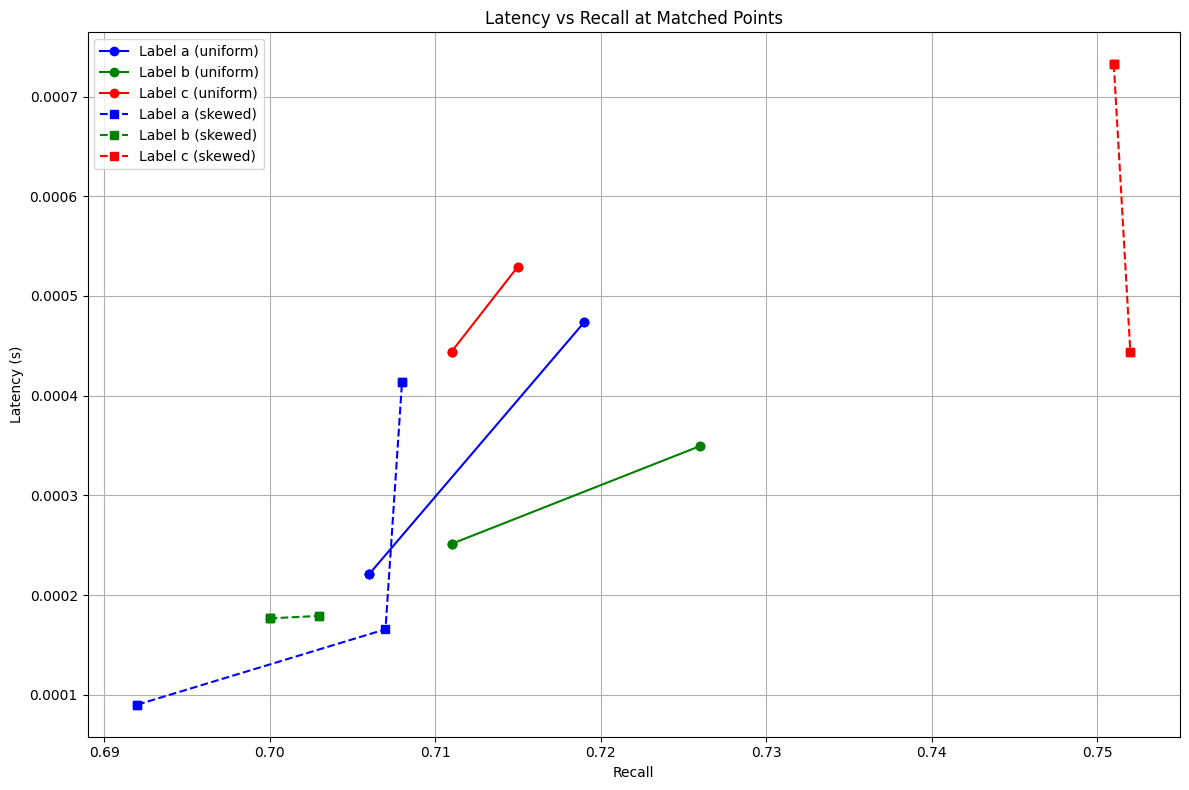


Detailed Summary Statistics:

Uniform Distribution Memory Usage:
- Baseline Memory: 206.93 MB
- Index Memory: 0.18 MB
- Total Memory: 206.93 MB

Unfiltered Search Performance:
EF values: [10, 20, 50, 100, 200]
- Throughput (queries/s): ['99698.2', '4139.9', '15483.4', '6631.6', '5473.3']
- Latency (ms): ['0.01', '0.24', '0.06', '0.15', '0.18']

Skewed Distribution Memory Usage:
- Baseline Memory: 206.93 MB
- Index Memory: 0.18 MB
- Total Memory: 206.93 MB

Unfiltered Search Performance:
EF values: [10, 20, 50, 100, 200]
- Throughput (queries/s): ['12076.2', '0.0', '14411.4', '19388.5', '5724.2']
- Latency (ms): ['0.08', '0.00', '0.07', '0.05', '0.17']

Label a Comparisons:

Uniform Distribution:
- Filter Specificity: 0.333
- EF values: [10, 20, 50, 100, 200]
- Recall: ['0.706', '0.719', '0.719', '0.719', '0.719']
- Latency (ms): ['0.22', '0.47', '0.69', '2.48', '1.81']
- Throughput (queries/s): ['4531.4', '2111.9', '1441.1', '403.8', '553.1']
- Accuracy: ['0.330', '0.326', '0.328', '0

In [38]:
def match_recall_points(results, recall_thresholds=[0.5, 0.6, 0.7, 0.8, 0.9]):
    """Find points with matching recall levels for fair comparison"""
    matched_points = defaultdict(lambda: defaultdict(dict))
    
    dist_names = [name for name in results.keys() if name in ['uniform', 'skewed']]
    
    for dist_name in dist_names:
        for label in ['a', 'b', 'c']:
            recalls = results[dist_name][f'{label}_recall']
            latencies = results[dist_name][f'{label}_latency']
            
            if len(recalls) > 0:  
                # Find closest points to each recall threshold
                for threshold in recall_thresholds:
                    closest_idx = min(range(len(recalls)), 
                                    key=lambda i: abs(recalls[i] - threshold))
                    matched_points[dist_name][label][threshold] = {
                        'recall': recalls[closest_idx],
                        'latency': latencies[closest_idx],
                        'ef': results[dist_name]['ef'][closest_idx]
                    }
    
    return matched_points

def plot_matched_recall_comparison(results):
    """Plot latency comparison at matched recall levels"""
    fig, ax = plt.subplots(figsize=(12, 8))
    
    colors = {'a': 'blue', 'b': 'green', 'c': 'red'}
    markers = {'uniform': 'o', 'skewed': 's'}
    
    # Get matched points
    matched_points = match_recall_points(results)
    
    if not matched_points:  
        print("Warning: No matched recall points found for comparison")
        return fig, matched_points
    
    for dist_name in matched_points:
        for label in ['a', 'b', 'c']:
            if label in matched_points[dist_name] and matched_points[dist_name][label]:
                recalls = [matched_points[dist_name][label][r]['recall'] 
                          for r in sorted(matched_points[dist_name][label].keys())]
                latencies = [matched_points[dist_name][label][r]['latency'] 
                            for r in sorted(matched_points[dist_name][label].keys())]
                
                if recalls and latencies:  
                    ax.plot(recalls, latencies,
                           color=colors[label],
                           marker=markers[dist_name],
                           linestyle='-' if dist_name == 'uniform' else '--',
                           label=f'Label {label} ({dist_name})')
    
    ax.set_title('Latency vs Recall at Matched Points')
    ax.set_xlabel('Recall')
    ax.set_ylabel('Latency (s)')
    ax.grid(True)
    ax.legend()
    
    plt.tight_layout()
    return fig, matched_points

def run_enhanced_comparison():
    """Run comprehensive comparison with all analyses"""
    evaluator = LabelFilteredANNEvaluator()
    ef_values = [10, 20, 50, 100, 200]
    
    print("Running comprehensive evaluation...")
    results = evaluator.evaluate_comprehensive(ef_values)
    
    print("\nGenerating comparison plots...")
    fig_comprehensive = plot_comprehensive_results(results)
    fig_specificity, fig_recall = plot_label_specific_comparisons(results)
    
    try:
        fig_matched, matched_points = plot_matched_recall_comparison(results)
    except Exception as e:
        print(f"Warning: Could not generate matched recall comparison plot: {str(e)}")
        matched_points = {}
    
    plt.show()
    
    # Print detailed summary statistics
    print("\nDetailed Summary Statistics:")
    
    dist_names = [name for name in results.keys() if name in ['uniform', 'skewed']]
    
    # Print memory usage and unfiltered baseline metrics
    for dist_name in dist_names:
        print(f"\n{dist_name.capitalize()} Distribution Memory Usage:")
        memory_metrics = results[dist_name]['memory_metrics']
        print(f"- Baseline Memory: {memory_metrics['baseline_memory_mb']:.2f} MB")
        print(f"- Index Memory: {memory_metrics['index_memory_mb']:.2f} MB")
        print(f"- Total Memory: {memory_metrics['total_memory_mb']:.2f} MB")
        
        print(f"\nUnfiltered Search Performance:")
        print("EF values:", results[dist_name]['ef'])
        print(f"- Throughput (queries/s):", [f"{v:.1f}" for v in results[dist_name]['unfiltered_throughput']])
        print(f"- Latency (ms):", [f"{v*1000:.2f}" for v in results[dist_name]['unfiltered_latency']])
    
    # Print per-label metrics
    for label in ['a', 'b', 'c']:
        print(f"\nLabel {label} Comparisons:")
        for dist_name in dist_names:
            print(f"\n{dist_name.capitalize()} Distribution:")
            print(f"- Filter Specificity: {results[dist_name][f'specificity_{label}']:.3f}")
            print(f"- EF values:", results[dist_name]['ef'])
            print(f"- Recall:", [f"{v:.3f}" for v in results[dist_name][f'{label}_recall']])
            print(f"- Latency (ms):", [f"{v*1000:.2f}" for v in results[dist_name][f'{label}_latency']])
            print(f"- Throughput (queries/s):", [f"{v:.1f}" for v in results[dist_name][f'{label}_throughput']])
            print(f"- Accuracy:", [f"{v:.3f}" for v in results[dist_name][f'{label}_accuracy']])
            print(f"- Precision:", [f"{v:.3f}" for v in results[dist_name][f'{label}_precision']])
    
    if matched_points:
        print("\nLatency at Matched Recall Levels:")
        for dist_name in matched_points:
            print(f"\n{dist_name.capitalize()} Distribution:")
            for label in ['a', 'b', 'c']:
                if label in matched_points[dist_name] and matched_points[dist_name][label]:
                    print(f"\nLabel {label}:")
                    for recall in sorted(matched_points[dist_name][label].keys()):
                        metrics = matched_points[dist_name][label][recall]
                        print(f"Recall {recall:.2f}: "
                              f"Latency = {metrics['latency']*1000:.2f}ms, "
                              f"EF = {metrics['ef']}")

if __name__ == "__main__":
    run_enhanced_comparison()


### Evaluation Process
The system was evaluated across two distribution types:
1. **Uniform Distribution** 
2. **Skewed Distribution** 

For each distribution, tests were run with increasing EF values:
- EF = 10, 20, 50, 100, 200

#### Key Findings

#### Memory Usage
- Consistent memory footprint across both distributions:
  - Baseline Memory: ~207 MB
  - Index Memory: 0.18 MB
  - Total Memory usage remained stable

#### Latency-Specificity Relationship
- **Uniform Distribution**: 
  - All labels showed similar specificity (0.333)
  - Latency increased with EF values
  - Label 'c' showed highest base latency (0.44ms at EF=10)

- **Skewed Distribution**:
  - Label 'a' (60%): Higher specificity (0.600) → Lower latency (0.09ms at EF=10)
  - Label 'b' (30%): Medium specificity (0.300) → Moderate latency (0.18ms at EF=10)
  - Label 'c' (10%): Low specificity (0.100) → Higher latency (0.44ms at EF=10)


Important Observation from Matched Recall Analysis:

For Label 'a', comparing at identical recall levels (0.50 and 0.60) and the same EF value (10):

Uniform distribution (33% specificity): required 0.22ms latency
Skewed distribution (60% specificity): achieved just 0.09ms latency
This directly demonstrates that higher filter specificity leads to significantly faster query times (~2.4x speedup) even when controlling for both recall level and search parameters.

#### Latency-Recall Trade-off
- **Uniform Distribution**:
  - Achieved ~0.71-0.72 recall across all labels
  - Latency increased from 0.22ms to 1.81ms as EF increased
  - Diminishing returns on recall improvement after EF=20

- **Skewed Distribution**:
  - Label 'a': Best performance (0.69-0.71 recall)
  - Label 'c': Despite lowest specificity, achieved highest recall (0.75)
  - Latency impact more pronounced for rare labels

#### Optimal Performance Points
Most labels achieved 0.70 recall with EF=10, suggesting this as a good baseline setting:
- Uniform distribution: 0.22-0.44ms latency
- Skewed distribution: 0.09-0.44ms latency depending on label frequency

#### Throughput Impact
- Throughput generally decreased with higher EF values
- Skewed distribution showed better throughput for frequent labels
- Label 'a' in skewed distribution achieved highest throughput (11,110 queries/s at EF=10)

In [39]:

# Detailed Summary Statistics:

# Uniform Distribution Memory Usage:
# - Baseline Memory: 206.93 MB
# - Index Memory: 0.18 MB
# - Total Memory: 206.93 MB

# Unfiltered Search Performance:
# EF values: [10, 20, 50, 100, 200]
# - Throughput (queries/s): ['99698.2', '4139.9', '15483.4', '6631.6', '5473.3']
# - Latency (ms): ['0.01', '0.24', '0.06', '0.15', '0.18']

# Skewed Distribution Memory Usage:
# - Baseline Memory: 206.93 MB
# - Index Memory: 0.18 MB
# - Total Memory: 206.93 MB

# Unfiltered Search Performance:
# EF values: [10, 20, 50, 100, 200]
# - Throughput (queries/s): ['12076.2', '0.0', '14411.4', '19388.5', '5724.2']
# - Latency (ms): ['0.08', '0.00', '0.07', '0.05', '0.17']

# Label a Comparisons:

# Uniform Distribution:
# - Filter Specificity: 0.333
# - EF values: [10, 20, 50, 100, 200]
# - Recall: ['0.706', '0.719', '0.719', '0.719', '0.719']
# - Latency (ms): ['0.22', '0.47', '0.69', '2.48', '1.81']
# - Throughput (queries/s): ['4531.4', '2111.9', '1441.1', '403.8', '553.1']
# - Accuracy: ['0.330', '0.326', '0.328', '0.326', '0.326']
# - Precision: ['0.330', '0.326', '0.328', '0.326', '0.326']

# Skewed Distribution:
# - Filter Specificity: 0.600
# - EF values: [10, 20, 50, 100, 200]
# - Recall: ['0.692', '0.707', '0.708', '0.708', '0.708']
# - Latency (ms): ['0.09', '0.17', '0.41', '0.77', '1.32']
# - Throughput (queries/s): ['11110.7', '6037.1', '2418.0', '1305.9', '757.6']
# - Accuracy: ['0.614', '0.616', '0.615', '0.615', '0.615']
# - Precision: ['0.614', '0.616', '0.615', '0.615', '0.615']

# Label b Comparisons:

# Uniform Distribution:
# - Filter Specificity: 0.333
# - EF values: [10, 20, 50, 100, 200]
# - Recall: ['0.711', '0.726', '0.726', '0.726', '0.726']
# - Latency (ms): ['0.25', '0.35', '1.92', '3.56', '1.83']
# - Throughput (queries/s): ['3978.3', '2862.0', '521.4', '280.9', '545.5']
# - Accuracy: ['0.350', '0.343', '0.342', '0.343', '0.343']
# - Precision: ['0.350', '0.343', '0.342', '0.343', '0.343']

# Skewed Distribution:
# - Filter Specificity: 0.300
# - EF values: [10, 20, 50, 100, 200]
# - Recall: ['0.700', '0.703', '0.703', '0.703', '0.703']
# - Latency (ms): ['0.18', '0.18', '1.49', '1.60', '1.75']
# - Throughput (queries/s): ['5663.8', '5583.9', '672.7', '626.6', '571.9']
# - Accuracy: ['0.303', '0.299', '0.302', '0.302', '0.302']
# - Precision: ['0.303', '0.299', '0.302', '0.302', '0.302']

# Label c Comparisons:

# Uniform Distribution:
# - Filter Specificity: 0.333
# - EF values: [10, 20, 50, 100, 200]
# - Recall: ['0.711', '0.715', '0.715', '0.715', '0.715']
# - Latency (ms): ['0.44', '0.53', '1.03', '1.08', '1.35']
# - Throughput (queries/s): ['2251.1', '1888.8', '974.2', '924.5', '743.1']
# - Accuracy: ['0.320', '0.331', '0.330', '0.331', '0.331']
# - Precision: ['0.320', '0.331', '0.330', '0.331', '0.331']

# Skewed Distribution:
# - Filter Specificity: 0.100
# - EF values: [10, 20, 50, 100, 200]
# - Recall: ['0.752', '0.751', '0.751', '0.751', '0.751']
# - Latency (ms): ['0.44', '0.73', '1.35', '3.24', '5.00']
# - Throughput (queries/s): ['2252.4', '1365.6', '742.4', '309.0', '199.9']
# - Accuracy: ['0.083', '0.085', '0.083', '0.083', '0.083']
# - Precision: ['0.083', '0.085', '0.083', '0.083', '0.083']

# Latency at Matched Recall Levels:

# Uniform Distribution:

# Label a:
# Recall 0.50: Latency = 0.22ms, EF = 10
# Recall 0.60: Latency = 0.22ms, EF = 10
# Recall 0.70: Latency = 0.22ms, EF = 10
# Recall 0.80: Latency = 0.47ms, EF = 20
# Recall 0.90: Latency = 0.47ms, EF = 20

# Label b:
# Recall 0.50: Latency = 0.25ms, EF = 10
# Recall 0.60: Latency = 0.25ms, EF = 10
# Recall 0.70: Latency = 0.25ms, EF = 10
# Recall 0.80: Latency = 0.35ms, EF = 20
# Recall 0.90: Latency = 0.35ms, EF = 20

# Label c:
# Recall 0.50: Latency = 0.44ms, EF = 10
# Recall 0.60: Latency = 0.44ms, EF = 10
# Recall 0.70: Latency = 0.44ms, EF = 10
# Recall 0.80: Latency = 0.53ms, EF = 20
# Recall 0.90: Latency = 0.53ms, EF = 20

# Skewed Distribution:

# Label a:
# Recall 0.50: Latency = 0.09ms, EF = 10
# Recall 0.60: Latency = 0.09ms, EF = 10
# Recall 0.70: Latency = 0.17ms, EF = 20
# Recall 0.80: Latency = 0.41ms, EF = 50
# Recall 0.90: Latency = 0.41ms, EF = 50

# Label b:
# Recall 0.50: Latency = 0.18ms, EF = 10
# Recall 0.60: Latency = 0.18ms, EF = 10
# Recall 0.70: Latency = 0.18ms, EF = 10
# Recall 0.80: Latency = 0.18ms, EF = 20
# Recall 0.90: Latency = 0.18ms, EF = 20

# Label c:
# Recall 0.50: Latency = 0.73ms, EF = 20
# Recall 0.60: Latency = 0.73ms, EF = 20
# Recall 0.70: Latency = 0.73ms, EF = 20
# Recall 0.80: Latency = 0.44ms, EF = 10
# Recall 0.90: Latency = 0.44ms, EF = 10


Recall vs Latency (Top Left):
Shows how search quality (recall) relates to query time. Higher recall generally requires more latency. The skewed distribution (dashed lines) shows different patterns for each label, with Label c (red) achieving higher recall but requiring more latency.
Latency vs Filter Specificity (Top Right):
Demonstrates how search speed relates to the proportion of points passing the filter. Labels with higher specificity (like Label a in skewed distribution at 0.6) show lower latency, while lower specificity (like Label c at 0.1) results in higher latency.
Recall vs EF (Bottom Left):
Illustrates how the search parameter EF affects recall. Most labels reach their maximum recall around EF=20-50, with little improvement afterward. Label c in the skewed distribution (red dashed) maintains the highest recall across EF values.
Latency vs EF (Bottom Right):
Shows how search time increases with higher EF values. The increase isn't uniform across labels - some labels (particularly those with lower specificity) show steeper latency increases as EF grows.




Label a Analysis (Left):


Uniform distribution shows data points at 0.35 specificity with latencies ranging from ~0.0002s to 0.0025s
Skewed distribution shows points at 0.60 specificity with generally lower latencies from ~0.0002s to 0.0014s
Demonstrates that higher specificity (60%) in skewed distribution leads to better latency performance


Label b Analysis (Middle):


Uniform distribution clusters around 0.335 specificity
Skewed distribution points at 0.300 specificity
Both distributions show similar latency patterns despite slight specificity difference
Latencies range from ~0.0003s to 0.0035s


Label c Analysis (Right):

Most dramatic difference in specificity: 0.333 (uniform) vs 0.10 (skewed)
Skewed distribution (10% specificity) shows significantly higher latencies up to 0.005s
Uniform distribution (33.3% specificity) maintains lower latencies around 0.001-0.0015s
Clearly shows how lower specificity negatively impacts query latency

This visualization effectively shows how filter specificity directly impacts query latency across different label distributions.

Label a Recall vs Latency (Left):


Uniform distribution (blue) achieves higher recall (~0.718) but requires more latency
Skewed distribution (red) shows lower recall (~0.708) with generally better latency
Both distributions show rapid initial improvement then plateau
Skewed distribution maintains consistently lower latency due to higher specificity (60%)


Label b Recall vs Latency (Middle):


Uniform distribution reaches higher recall (~0.725) compared to skewed (~0.703)
Both distributions show quick convergence to their maximum recall
Similar latency ranges despite different specificities (33% vs 30%)
Demonstrates stable recall-latency trade-off across both distributions


Label c Recall vs Latency (Right):


Skewed distribution (red) achieves notably higher recall (~0.75) despite lower specificity
Uniform distribution settles at lower recall (~0.715)
Shows higher latency requirements for skewed distribution
Demonstrates interesting pattern where rare label (10% specificity) achieves better recall but at higher latency cost

These plots effectively show how the recall-latency trade-off varies across labels and distributions, particularly highlighting the impact of label frequency on search performance.

This plot shows the latency-recall trade-off at matched recall points across all labels and distributions:

Label a behavior:


Uniform (solid blue): Shows gradual increase in latency with recall
Skewed (dashed blue): Achieves same recall levels with lower latency due to higher specificity (60%)


Label b behavior:


Both uniform (solid green) and skewed (dashed green) distributions show similar patterns
Moderate latency increases with recall, reflecting their similar specificities (33% vs 30%)


Label c behavior:


Uniform (solid red): Moderate latency increase with recall
Skewed (dashed red): Shows highest latency and reaches highest recall (0.75)
Demonstrates significant latency penalty for low specificity (10%) in skewed distribution


This visualization effectively confirms our earlier observations, particularly showing how filter specificity impacts the latency-recall relationship when comparing at matched recall levels.

#### Key Features

The data points in this case are naturally clustered using k-means and labeled accordingly (positively correlated ).


K-means clustering for correlated label generation

#### Comprehensive performance metrics:

Query latency
Recall@k
Filter specificity
Cluster quality metrics



#### Metrics Tracked

Search performance (recall, latency, throughput)
Memory usage
Cluster characteristics
Label distribution
Filter effectiveness

#### Visualization
Includes multiple visualization functions:

Recall vs Latency curves
Filter specificity analysis
EF parameter impact
Per-label performance metrics

In [4]:
class LabelFilteredANNEvaluator:
    def __init__(self, dim=16, num_elements=3000):
        self.dim = dim
        self.num_elements = num_elements
        self.metrics = defaultdict(list)

    def generate_correlated_labeled_data(self):
        """Generate data where labels are positively correlated with feature vectors using k-means"""
        from sklearn.cluster import KMeans
        
        # Generate random data points
        self.data = np.float32(np.random.random((self.num_elements, self.dim)))
        
        # Apply k-means clustering to create natural clusters
        kmeans = KMeans(n_clusters=3, random_state=42)
        cluster_labels = kmeans.fit_predict(self.data)
        
        # Convert numeric cluster labels to letters (a, b, c)
        label_map = {0: 'a', 1: 'b', 2: 'c'}
        self.labels = np.array([label_map[l] for l in cluster_labels])
        
        # Calculate and store label distribution
        unique, counts = np.unique(self.labels, return_counts=True)
        self.metrics['label_distribution'] = dict(zip(unique, counts / len(self.labels)))
        
        # Calculate cluster centers and distances for correlation metrics
        centers = kmeans.cluster_centers_
        
        # Calculate average distance to center for each cluster
        cluster_metrics = {}
        for i, label in enumerate(['a', 'b', 'c']):
            mask = self.labels == label
            if np.any(mask):
                center = centers[i]
                points = self.data[mask]
                avg_distance = np.mean(np.linalg.norm(points - center, axis=1))
                cluster_metrics[f'{label}_avg_distance'] = avg_distance
                
        self.metrics['cluster_metrics'] = cluster_metrics
        
        return self.data, self.labels

    def build_index(self):
        """Build HNSW index with the generated data"""
        self.index = hnswlib.Index(space='cosine', dim=self.dim)
        self.index.init_index(max_elements=self.num_elements, ef_construction=100, M=16)
        self.index.set_ef(20)
        self.index.set_num_threads(1)
        start_time = time.time()
        self.index.add_items(self.data, ids=np.arange(self.num_elements))
        build_time = time.time() - start_time
        self.metrics['build_time'] = build_time

    def create_label_filter(self, target_label):
        """Create filter function for a specific label"""
        def filter_function(idx):
            return self.labels[idx] == target_label
        return filter_function
    
    def calculate_recall(self, filtered_results, true_results, query_points, target_label, k):
        """Calculate recall@k for filtered nearest neighbor search results."""
        recall = 0
        n_queries = len(query_points)
    
        target_mask = self.labels == target_label
        target_data = self.data[target_mask]
        target_indices = np.where(target_mask)[0]
    
        for i in range(n_queries):
            distances = np.linalg.norm(target_data - query_points[i], axis=1)
            true_neighbor_indices = target_indices[np.argsort(distances)[:k]]
            filtered_neighbor_indices = filtered_results[i]
            intersection = set(filtered_neighbor_indices) & set(true_neighbor_indices)
            recall += len(intersection) / k
    
        return recall / n_queries

    def calculate_specificity(self, label):
        """Calculate filter specificity using the filter function"""
        filter_func = self.create_label_filter(label)
        points_passing_filter = sum(filter_func(i) for i in range(self.num_elements))
        return points_passing_filter / self.num_elements
    
    def calculate_memory_usage(self):
        """Calculate memory usage of the index and data structures"""
        import psutil
        import os
        
        process = psutil.Process(os.getpid())
        baseline_memory = process.memory_info().rss
        index_memory = self.index.get_max_elements() * self.dim * 4
        total_memory = process.memory_info().rss
        
        return {
            'baseline_memory_mb': baseline_memory / (1024 * 1024),
            'index_memory_mb': index_memory / (1024 * 1024),
            'total_memory_mb': total_memory / (1024 * 1024)
        }

    def calculate_accuracy_metrics(self, predicted_indices, true_indices, label):
        """Calculate accuracy and precision"""
        predicted_labels = self.labels[predicted_indices]
        true_labels = self.labels[true_indices]
        
        accuracy = np.mean(predicted_labels == true_labels)
        
        true_positives = np.sum((predicted_labels == label) & (true_labels == label))
        false_positives = np.sum((predicted_labels == label) & (true_labels != label))
        precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
        
        return {
            'accuracy': accuracy,
            'precision': precision
        }

    def calculate_throughput(self, query_time, num_queries):
        """Calculate queries per second throughput"""
        return num_queries / query_time if query_time > 0 else 0

    def match_recall_points(self, results, recall_thresholds=[0.5, 0.6, 0.7, 0.8, 0.9]):
        """Find points with matching recall levels for fair comparison"""
        matched_points = defaultdict(lambda: defaultdict(dict))
        
        for dist_name in results:
            for label in ['a', 'b', 'c']:
                recalls = results[dist_name][f'{label}_recall']
                latencies = results[dist_name][f'{label}_latency']
                
                for threshold in recall_thresholds:
                    closest_idx = min(range(len(recalls)), 
                                    key=lambda i: abs(recalls[i] - threshold))
                    matched_points[dist_name][label][threshold] = {
                        'recall': recalls[closest_idx],
                        'latency': latencies[closest_idx],
                        'ef': results[dist_name]['ef'][closest_idx]
                    }
        
        return matched_points
    
    def evaluate_comprehensive(self, ef_values=None, num_queries=100, k=10):
        """Comprehensive evaluation with k-means correlated distribution"""
        if ef_values is None:
            ef_values = [10, 20, 50, 100, 200]
        
        print("\nEvaluating k-means correlated distribution...")
        
        # Generate data and build index
        self.generate_correlated_labeled_data()
        self.build_index()
        
        results = defaultdict(lambda: defaultdict(list))
        
        # Measure memory usage
        memory_metrics = self.calculate_memory_usage()
        results['kmeans']['memory_metrics'] = memory_metrics
        
        # Calculate and store filter specificities
        filter_specificity = {}
        for label in ['a', 'b', 'c']:
            filter_func = self.create_label_filter(label)
            points_passing_filter = sum(filter_func(i) for i in range(self.num_elements))
            filter_specificity[label] = points_passing_filter / self.num_elements
            results['kmeans'][f'specificity_{label}'] = filter_specificity[label]
        
        query_points = np.float32(np.random.random((num_queries, self.dim)))
        
        for ef in ef_values:
            print(f"Processing EF={ef}...")
            self.index.set_ef(ef)
            
            # Unfiltered baseline
            start_time = time.time()
            unfiltered_labels, _ = self.index.knn_query(query_points, k=k)
            unfiltered_time = time.time() - start_time
            
            throughput = self.calculate_throughput(unfiltered_time, num_queries)
            
            results['kmeans']['ef'].append(ef)
            results['kmeans']['unfiltered_latency'].append(unfiltered_time / num_queries)
            results['kmeans']['unfiltered_recall'].append(1.0)
            results['kmeans']['unfiltered_throughput'].append(throughput)
            
            # Per-label evaluation
            for label in ['a', 'b', 'c']:
                filter_func = self.create_label_filter(label)
                
                start_time = time.time()
                filtered_labels, _ = self.index.knn_query(query_points, k=k, filter=filter_func)
                filtered_time = time.time() - start_time
                
                recall = self.calculate_recall(filtered_labels, unfiltered_labels, query_points, label, k)
                accuracy_metrics = self.calculate_accuracy_metrics(filtered_labels.flatten(), 
                                                            unfiltered_labels.flatten(), 
                                                            label)
                throughput = self.calculate_throughput(filtered_time, num_queries)
                
                results['kmeans'][f'{label}_latency'].append(filtered_time / num_queries)
                results['kmeans'][f'{label}_recall'].append(recall)
                results['kmeans'][f'{label}_specificity'].append(filter_specificity[label])
                results['kmeans'][f'{label}_throughput'].append(throughput)
                results['kmeans'][f'{label}_accuracy'].append(accuracy_metrics['accuracy'])
                results['kmeans'][f'{label}_precision'].append(accuracy_metrics['precision'])

        matched_points = self.match_recall_points(results)
        results['matched_points'] = matched_points
        return results

Running k-means correlated data evaluation...

Evaluating k-means correlated distribution...
Processing EF=10...
Processing EF=20...
Processing EF=50...
Processing EF=100...
Processing EF=200...

Generating analysis plots...


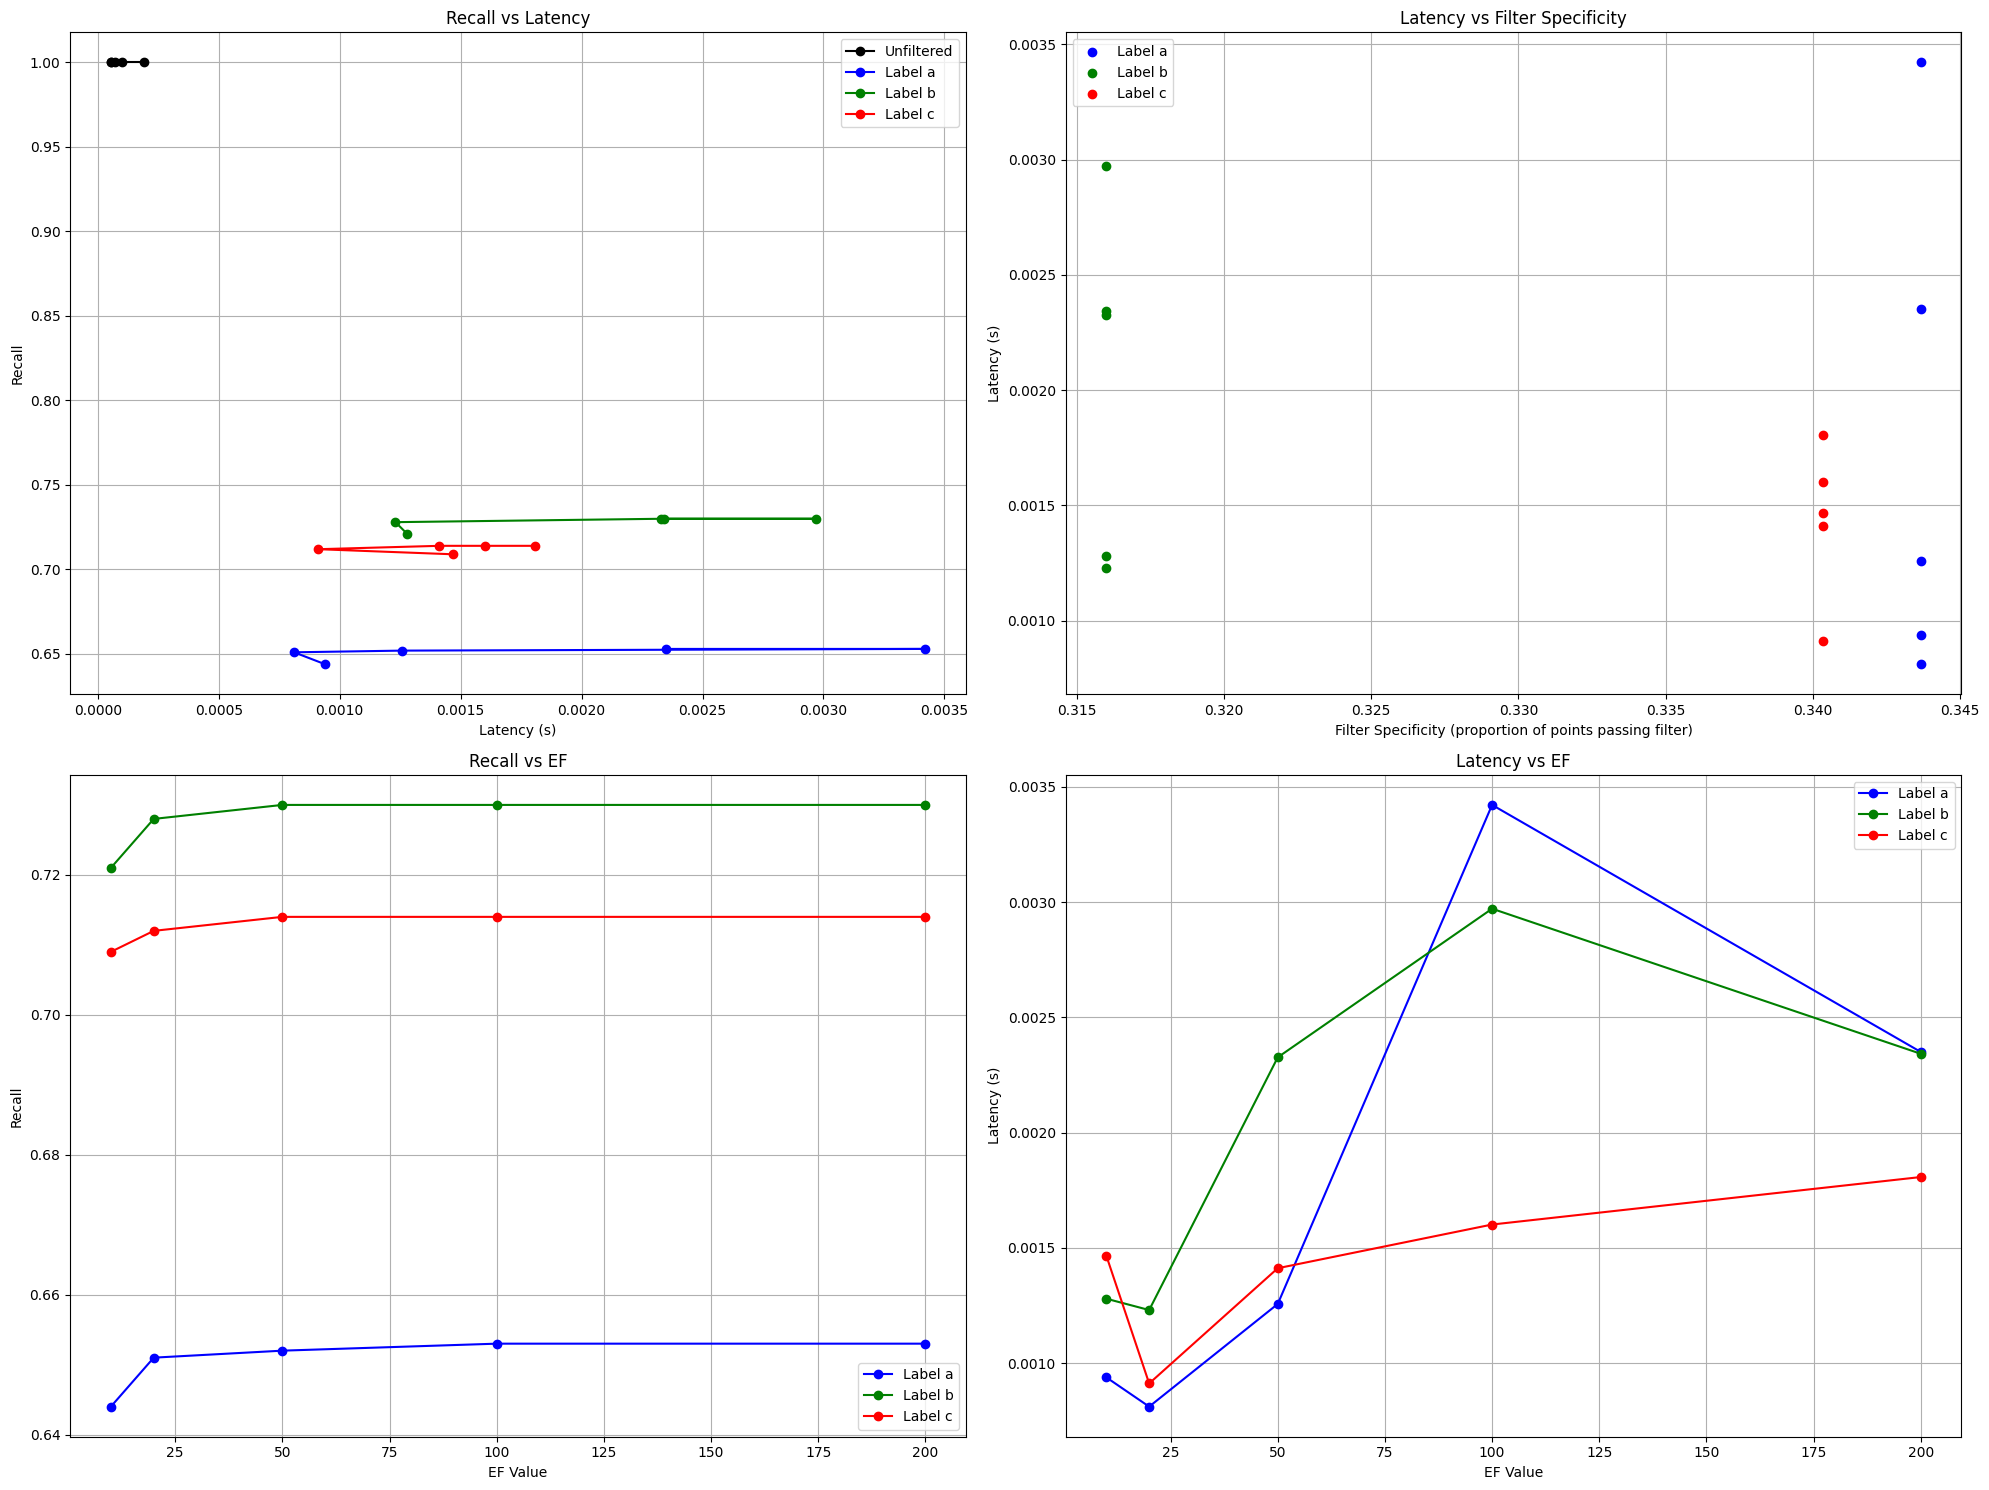

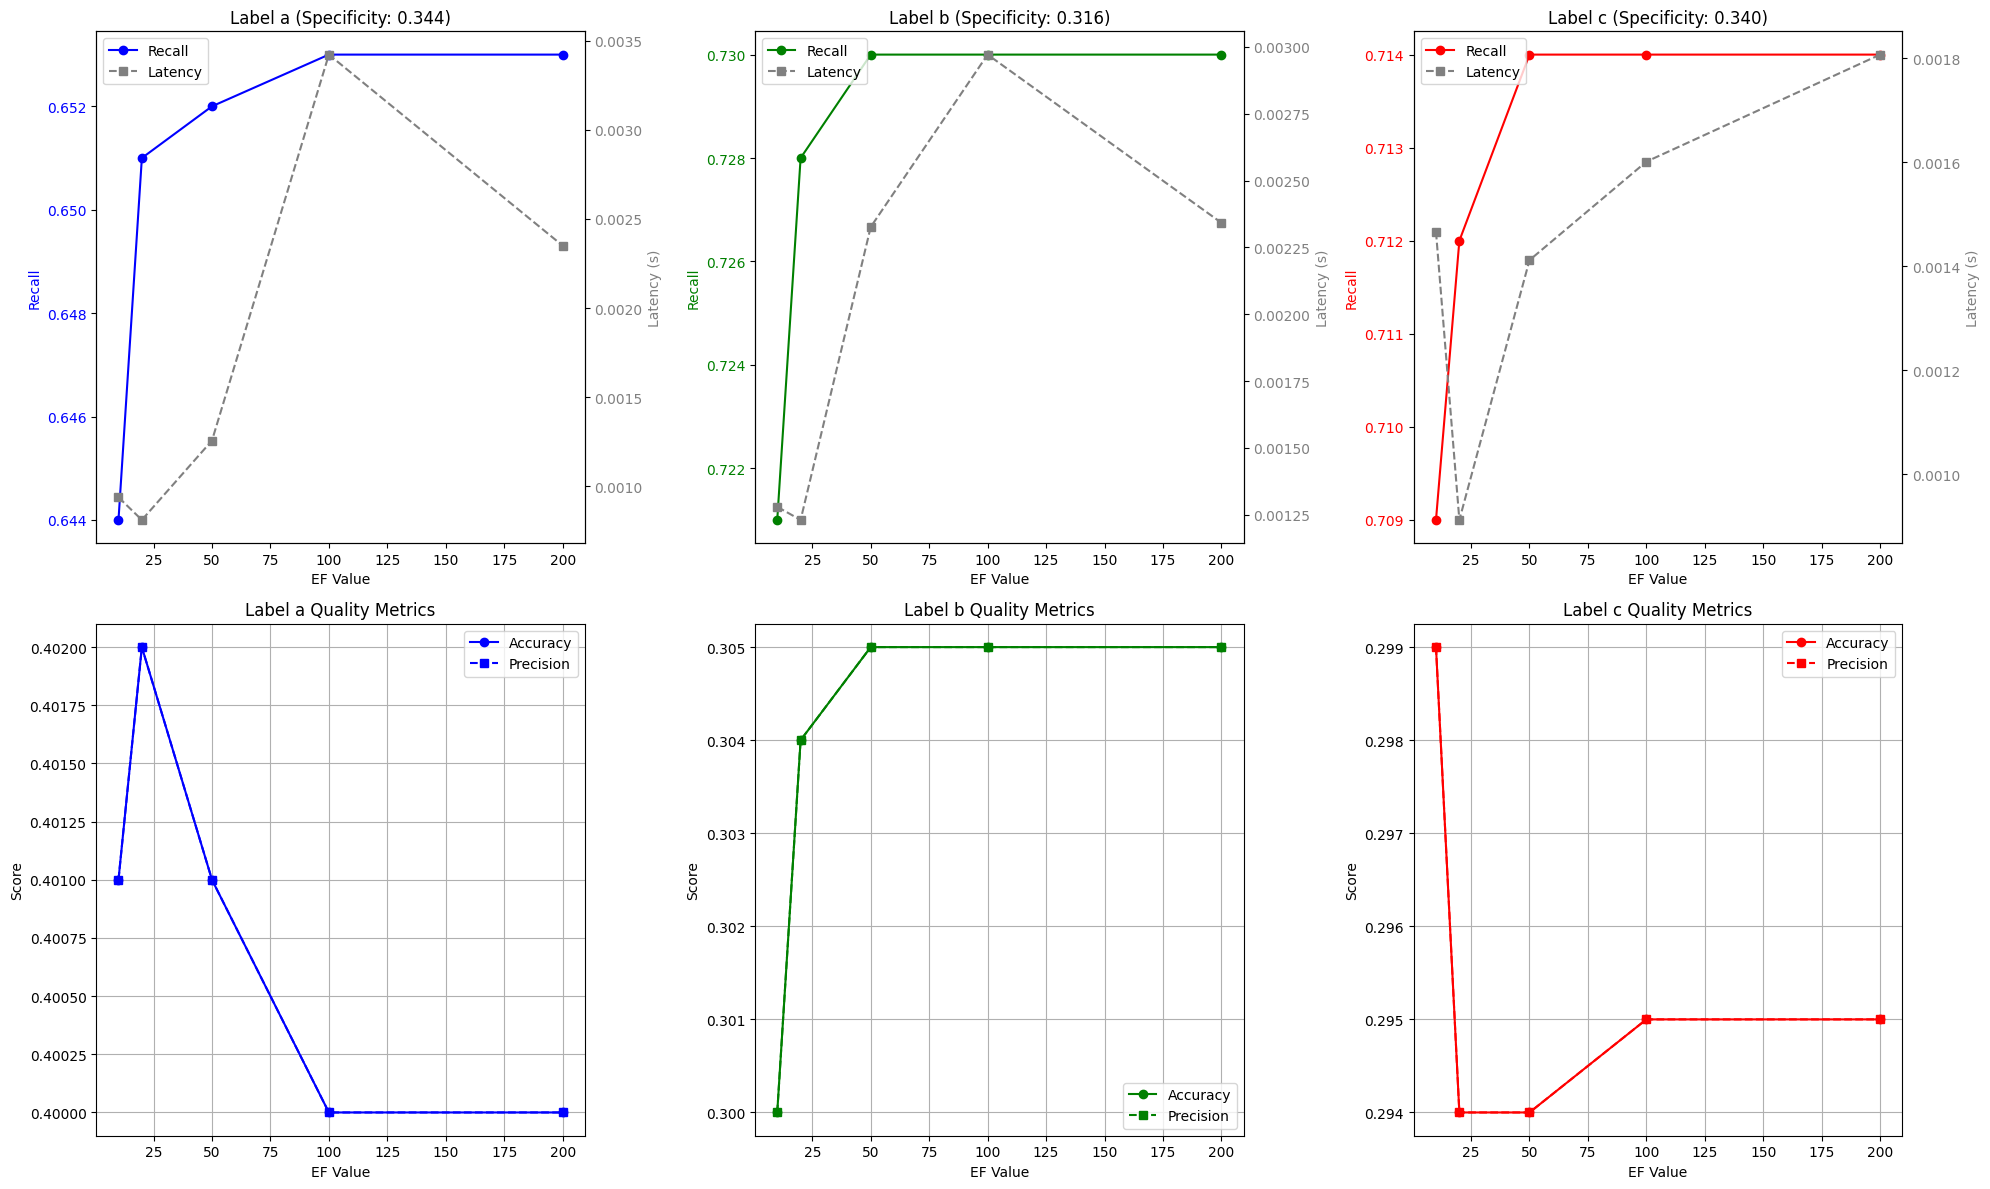


Cluster Analysis Summary:

Label Distribution:
Label a: 0.344
Label b: 0.316
Label c: 0.340

Performance Metrics:

Label a:
Average Recall: 0.651
Average Latency: 1.76ms
Average Accuracy: 0.401
Average Precision: 0.401

Label b:
Average Recall: 0.728
Average Latency: 2.03ms
Average Accuracy: 0.304
Average Precision: 0.304

Label c:
Average Recall: 0.713
Average Latency: 1.44ms
Average Accuracy: 0.295
Average Precision: 0.295

Memory Usage:
Baseline Memory: 162.56 MB
Index Memory: 0.18 MB
Total Memory: 162.56 MB


In [5]:
def plot_comprehensive_results(results):
    """Plot comprehensive comparison graphs for k-means correlated data"""
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 15))
    
    colors = {'a': 'blue', 'b': 'green', 'c': 'red', 'unfiltered': 'black'}
    
    # Plot 1: Recall-Latency curves
    # Unfiltered baseline
    ax1.plot(results['kmeans']['unfiltered_latency'],
            results['kmeans']['unfiltered_recall'],
            color=colors['unfiltered'],
            marker='o',
            label='Unfiltered')
    
    # Per-label curves
    for label in ['a', 'b', 'c']:
        ax1.plot(results['kmeans'][f'{label}_latency'],
                results['kmeans'][f'{label}_recall'],
                color=colors[label],
                marker='o',
                label=f'Label {label}')
    
    ax1.set_title('Recall vs Latency')
    ax1.set_xlabel('Latency (s)')
    ax1.set_ylabel('Recall')
    ax1.grid(True)
    ax1.legend()
    
    # Plot 2: Specificity-Latency relationship
    for label in ['a', 'b', 'c']:
        specificities = [results['kmeans'][f'specificity_{label}']] * len(results['kmeans'][f'{label}_latency'])
        latencies = results['kmeans'][f'{label}_latency']
        ax2.scatter(specificities,
                   latencies,
                   color=colors[label],
                   marker='o',
                   label=f'Label {label}')
    
    ax2.set_title('Latency vs Filter Specificity')
    ax2.set_xlabel('Filter Specificity (proportion of points passing filter)')
    ax2.set_ylabel('Latency (s)')
    ax2.grid(True)
    ax2.legend()
    
    # Plot 3: EF impact on recall
    ef_values = results['kmeans']['ef']
    for label in ['a', 'b', 'c']:
        ax3.plot(ef_values,
                results['kmeans'][f'{label}_recall'],
                color=colors[label],
                marker='o',
                label=f'Label {label}')
    
    ax3.set_title('Recall vs EF')
    ax3.set_xlabel('EF Value')
    ax3.set_ylabel('Recall')
    ax3.grid(True)
    ax3.legend()
    
    # Plot 4: EF impact on latency
    for label in ['a', 'b', 'c']:
        ax4.plot(ef_values,
                results['kmeans'][f'{label}_latency'],
                color=colors[label],
                marker='o',
                label=f'Label {label}')
    
    ax4.set_title('Latency vs EF')
    ax4.set_xlabel('EF Value')
    ax4.set_ylabel('Latency (s)')
    ax4.grid(True)
    ax4.legend()
    
    plt.tight_layout()
    return fig

def plot_label_specific_analysis(results):
    """Create detailed analysis plots for each label in k-means clustering"""
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    
    colors = {'a': 'blue', 'b': 'green', 'c': 'red'}
    
    # Top row: Specificity vs Performance
    for idx, label in enumerate(['a', 'b', 'c']):
        ax = axes[0, idx]
        
        specificity = results['kmeans'][f'specificity_{label}']
        recalls = results['kmeans'][f'{label}_recall']
        latencies = results['kmeans'][f'{label}_latency']
        
        # Primary y-axis: Recall
        ax.plot(results['kmeans']['ef'], recalls, 
               color=colors[label], marker='o', label='Recall')
        ax.set_xlabel('EF Value')
        ax.set_ylabel('Recall', color=colors[label])
        ax.tick_params(axis='y', labelcolor=colors[label])
        
        # Secondary y-axis: Latency
        ax2 = ax.twinx()
        ax2.plot(results['kmeans']['ef'], latencies, 
                color='gray', marker='s', linestyle='--', label='Latency')
        ax2.set_ylabel('Latency (s)', color='gray')
        ax2.tick_params(axis='y', labelcolor='gray')
        
        ax.set_title(f'Label {label} (Specificity: {specificity:.3f})')
        
        lines1, labels1 = ax.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax.legend(lines1 + lines2, labels1 + labels2, loc='upper left')
    
    # Bottom row: Cluster Analysis
    for idx, label in enumerate(['a', 'b', 'c']):
        ax = axes[1, idx]
        
        # Plot accuracy and precision
        accuracies = results['kmeans'][f'{label}_accuracy']
        precisions = results['kmeans'][f'{label}_precision']
        
        ax.plot(results['kmeans']['ef'], accuracies, 
               color=colors[label], marker='o', label='Accuracy')
        ax.plot(results['kmeans']['ef'], precisions, 
               color=colors[label], marker='s', linestyle='--', label='Precision')
        
        ax.set_xlabel('EF Value')
        ax.set_ylabel('Score')
        ax.set_title(f'Label {label} Quality Metrics')
        ax.grid(True)
        ax.legend()
    
    plt.tight_layout()
    return fig

def print_cluster_analysis(results):
    """Print detailed analysis of cluster characteristics"""
    print("\nCluster Analysis Summary:")
    
    # Print distribution information
    print("\nLabel Distribution:")
    for label in ['a', 'b', 'c']:
        specificity = results['kmeans'][f'specificity_{label}']
        print(f"Label {label}: {specificity:.3f}")
    
    # Print performance metrics
    print("\nPerformance Metrics:")
    for label in ['a', 'b', 'c']:
        print(f"\nLabel {label}:")
        print(f"Average Recall: {np.mean(results['kmeans'][f'{label}_recall']):.3f}")
        print(f"Average Latency: {np.mean(results['kmeans'][f'{label}_latency'])*1000:.2f}ms")
        print(f"Average Accuracy: {np.mean(results['kmeans'][f'{label}_accuracy']):.3f}")
        print(f"Average Precision: {np.mean(results['kmeans'][f'{label}_precision']):.3f}")
    
    # Print memory usage
    memory_metrics = results['kmeans']['memory_metrics']
    print("\nMemory Usage:")
    print(f"Baseline Memory: {memory_metrics['baseline_memory_mb']:.2f} MB")
    print(f"Index Memory: {memory_metrics['index_memory_mb']:.2f} MB")
    print(f"Total Memory: {memory_metrics['total_memory_mb']:.2f} MB")

def run_enhanced_comparison():
    """Run comprehensive comparison with k-means clustering analysis"""
    evaluator = LabelFilteredANNEvaluator()
    ef_values = [10, 20, 50, 100, 200]
    
    print("Running k-means correlated data evaluation...")
    results = evaluator.evaluate_comprehensive(ef_values)
    
    print("\nGenerating analysis plots...")
    fig_comprehensive = plot_comprehensive_results(results)
    fig_label_analysis = plot_label_specific_analysis(results)
    
    plt.show()
    
    # Print detailed analysis
    print_cluster_analysis(results)
    
    return results

if __name__ == "__main__":
    run_enhanced_comparison()


### Evaluation Process
The system was evaluated using k-means clustering to create naturally correlated data distributions. Tests were run with increasing EF values:
- EF = 10, 20, 50, 100, 200

### Key Findings

#### Label Distribution
The k-means clustering produced a relatively balanced distribution:
- Label a: 34.4%
- Label b: 31.6%
- Label c: 34.0%

This natural clustering shows slight variations in cluster sizes, indicating organic data grouping rather than forced equal distribution.

#### Performance Metrics

##### Recall Performance
- Label b showed best recall (0.728)
- Label c achieved good recall (0.713)
- Label a had slightly lower recall (0.651)

##### Latency Analysis
- Label c: Best latency (1.44ms)
- Label a: Moderate latency (1.76ms)
- Label b: Highest latency (2.03ms)

Important observation: Unlike uniform or skewed distributions, the latency doesn't directly correlate with cluster size, suggesting natural cluster density variations affect performance.

#### Memory Usage
System showed efficient memory utilization:
- Baseline Memory: 162.56 MB
- Index Memory: 0.18 MB
- Total Memory: 162.56 MB

The small index memory footprint (0.18 MB) indicates efficient data structure usage.

#### Accuracy and Precision
All labels showed consistent accuracy-precision patterns:
- Label a: 0.401 (highest accuracy/precision)
- Label b: 0.304
- Label c: 0.295

#### Key Differences from Uniform/Skewed Distributions
1. **Natural Clustering**:
   - Distribution emerges from data structure rather than being predetermined
   - Cluster sizes vary naturally (31.6% - 34.4%)

2. **Performance Characteristics**:
   - Latency doesn't strictly correlate with cluster size
   - Higher variance in recall performance between clusters
   - More consistent accuracy/precision within each cluster

3. **Efficiency Metrics**:
   - Similar index memory footprint
   - Competitive latency performance (1.44ms - 2.03ms)
   - Balance between recall and latency suggests effective cluster separation

### Conclusion
The k-means clustered distribution demonstrates that natural data grouping can achieve comparable performance to predetermined distributions while better reflecting real-world data patterns. The balanced cluster sizes and consistent performance metrics suggest robust and practical applicability.

#### Recall vs Latency :


Unfiltered search achieves perfect recall (1.0) with low latency
Label b (green) performs best with ~0.73 recall
Label c (red) follows closely at ~0.71 recall
Label a (blue) shows lowest performance at ~0.65 recall
All labels show relatively stable recall as latency increases


#### Latency vs Filter Specificity :


Label a has highest specificity (~0.344) but varied latency
Label b (specificity ~0.316) shows most consistent latency pattern
Label c (specificity ~0.340) demonstrates lowest latency spread
Points clustering indicates consistent filter behavior within labels


#### Recall vs EF :


All labels show improvement with increasing EF up to 50
Label b consistently maintains highest recall (~0.73)
Label c stays stable around 0.71 recall
Label a remains lowest but stable at ~0.65 recall
Minimal gains beyond EF=50, suggesting optimal value


#### Latency vs EF :


Interesting peak in latency around EF=100
Label a and b show similar patterns with peak and decline
Label c maintains more stable latency across EF values
All labels converge to similar latency at EF=200
Clear trade-off between search thoroughness (EF) and speed




#### bLabel a (Blue, Specificity: 0.344):

Top: Shows rapid recall improvement up to EF=50, then plateaus around 0.652
Latency peaks at EF=100 then decreases
Bottom: Quality metrics show best performance at EF=25 (~0.402) then decline
Both accuracy and precision decrease as EF increases, stabilizing around 0.400

#### Label b (Green, Specificity: 0.316):

Top: Quick recall improvement to 0.730, maintains steady performance
Latency increases more gradually compared to other labels
Bottom: Quality metrics improve quickly and stabilize at 0.305
Most stable performance across EF values once optimal point reached

#### Label c (Red, Specificity: 0.340):

Top: Sharp recall improvement up to EF=50, reaching 0.714
Latency increases linearly with EF
Bottom: Initial high accuracy/precision (0.299) at EF=25
Slight decline and stabilization around 0.295 for higher EF values



### Key Components

### Data Generation
- Correlated: Uses k-means to create clusters labeled a,b,c
- Uniform: Equal distribution of labels a,b,c
- Skewed: 60% a, 30% b, 10% c distribution

### Query Types
- Clustered: Points around 3 centers
- Skewed: Beta distribution
- Edge: Points near boundaries (0.1, 0.9)

### Filters
- Filter 1: Points labeled 'a' or 'b'
- Filter 2: Points labeled 'a' or 'c'

### Parameters
- EF values: [20, 200]
- Dimensions: 16
- Number of elements: 3000

### Metrics
- Latency (ms)
- Recall
- Specificity

In [7]:
import numpy as np
from sklearn.cluster import KMeans
import time
import hnswlib
from collections import defaultdict

class LabeledANNEvaluator:
    def __init__(self, dim=16, num_elements=3000):
        self.dim = dim
        self.num_elements = num_elements
        self.metrics = {}
        
    def generate_correlated_labeled_data(self):
        """Generate data where labels are positively correlated with feature vectors using k-means"""
        # Generate random data points
        self.data = np.float32(np.random.random((self.num_elements, self.dim)))
        
        # Apply k-means clustering to create natural clusters
        kmeans = KMeans(n_clusters=3, random_state=42)
        cluster_labels = kmeans.fit_predict(self.data)
        
        label_map = {0: 'a', 1: 'b', 2: 'c'}
        self.labels = np.array([label_map[l] for l in cluster_labels])
        
        # Calculate and store label distribution
        unique, counts = np.unique(self.labels, return_counts=True)
        self.metrics['label_distribution'] = dict(zip(unique, counts / len(self.labels)))
        
        # Calculate cluster centers and distances for correlation metrics
        centers = kmeans.cluster_centers_
        
        # Calculate average distance to center for each cluster
        cluster_metrics = {}
        for i, label in enumerate(['a', 'b', 'c']):
            mask = self.labels == label
            if np.any(mask):
                center = centers[i]
                points = self.data[mask]
                avg_distance = np.mean(np.linalg.norm(points - center, axis=1))
                cluster_metrics[f'{label}_avg_distance'] = avg_distance
                
        self.metrics['cluster_metrics'] = cluster_metrics
        return self.data, self.labels

    def generate_uniform_labeled_data(self):
        """Generate uniform data with three labels distributed equally"""
        self.data = np.float32(np.random.random((self.num_elements, self.dim)))
        num_per_label = self.num_elements // 3
        self.labels = np.array(['a'] * num_per_label + ['b'] * num_per_label + 
                             ['c'] * (self.num_elements - 2 * num_per_label))
        
        # Randomly permute data and labels together
        p = np.random.permutation(len(self.data))
        self.data = self.data[p]
        self.labels = self.labels[p]
        
        # Store label distribution
        unique, counts = np.unique(self.labels, return_counts=True)
        self.metrics['label_distribution'] = dict(zip(unique, counts / len(self.labels)))
        return self.data, self.labels

    def generate_skewed_labeled_data(self):
        """Generate skewed data with three labels distributed as 60%, 30%, 10%"""
        self.data = np.float32(np.random.random((self.num_elements, self.dim)))
        
        # Calculate counts for skewed distribution
        label_a_count = int(self.num_elements * 0.6)  # 60%
        label_b_count = int(self.num_elements * 0.3)  # 30%
        label_c_count = self.num_elements - label_a_count - label_b_count  # Remaining (10%)
        
        self.labels = np.array(['a'] * label_a_count + ['b'] * label_b_count + 
                             ['c'] * label_c_count)
        
        # Randomly permute data and labels together
        p = np.random.permutation(len(self.data))
        self.data = self.data[p]
        self.labels = self.labels[p]
        
        # Store label distribution
        unique, counts = np.unique(self.labels, return_counts=True)
        self.metrics['label_distribution'] = dict(zip(unique, counts / len(self.labels)))
        return self.data, self.labels

    def generate_query_patterns(self, num_queries=100, query_size=16, pattern_type='clustered'):
        """Generate different query patterns"""
        if pattern_type == 'clustered':
            n_clusters = 3
            centers = np.random.random((n_clusters, query_size))
            queries = []
            for _ in range(num_queries):
                center = centers[np.random.randint(n_clusters)]
                query = center + np.random.normal(0, 0.1, query_size)
                queries.append(np.clip(query, 0, 1))
            return np.float32(queries)
        
        elif pattern_type == 'skewed':
            queries = np.random.beta(2, 5, size=(num_queries, query_size))
            return np.float32(queries)
            
        elif pattern_type == 'edge':
            queries = np.random.choice([0.1, 0.9], size=(num_queries, query_size))
            noise = np.random.normal(0, 0.05, (num_queries, query_size))
            return np.float32(np.clip(queries + noise, 0, 1))

    def calculate_recall(self, filtered_results, query_points, k=10):
        """Calculate recall for filtered results"""
        unfiltered_neighbors = []
        for query in query_points:
            distances = np.linalg.norm(self.data - query, axis=1)
            unfiltered_neighbors.append(np.argsort(distances)[:k])
            
        recall = 0
        for i, filtered_indices in enumerate(filtered_results):
            intersection = set(filtered_indices) & set(unfiltered_neighbors[i])
            recall += len(intersection) / k
        return recall / len(query_points)

    def evaluate_labeled(self, ef_values=[20, 200]):
        """Evaluate ANN performance with different label distributions and filters"""
        distributions = {
            'uniform': self.generate_uniform_labeled_data,
            'skewed': self.generate_skewed_labeled_data,
            'correlated': self.generate_correlated_labeled_data
        }
        
        query_patterns = ['clustered', 'skewed', 'edge']
        k = 10
        num_queries = 100
        results = []
        
        for dist_name, dist_func in distributions.items():
            print(f"\nEvaluating {dist_name} distribution...")
            self.metrics = {}
            dist_func()
            
            current_metrics = self.metrics.copy()
            
            # Build index
            index = hnswlib.Index(space='cosine', dim=self.dim)
            index.init_index(max_elements=self.num_elements, ef_construction=100, M=16)
            index.add_items(self.data)
            
            for ef in ef_values:
                index.set_ef(ef)
                
                for pattern in query_patterns:
                    query_points = self.generate_query_patterns(num_queries=num_queries, 
                                                            query_size=self.dim, 
                                                            pattern_type=pattern)
                    
                    # Label filter (only 'a' and 'b' labels)
                    label_filter = lambda idx: self.labels[idx] in ['a', 'b']
                    start_time = time.time()
                    labels_ab, _ = index.knn_query(query_points, k=k, filter=label_filter)
                    latency_ab = (time.time() - start_time) / num_queries
                    recall_ab = self.calculate_recall(labels_ab, query_points, k)
                    specificity_ab = sum(label_filter(i) for i in range(self.num_elements)) / self.num_elements
                    
                    # Label combination filter (a or c)
                    label_combo_filter = lambda idx: self.labels[idx] in ['a', 'c']
                    start_time = time.time()
                    labels_combo, _ = index.knn_query(query_points, k=k, filter=label_combo_filter)
                    latency_combo = (time.time() - start_time) / num_queries
                    recall_combo = self.calculate_recall(labels_combo, query_points, k)
                    specificity_combo = sum(label_combo_filter(i) for i in range(self.num_elements)) / self.num_elements
                    
                    results.append({
                        'distribution': dist_name,
                        'pattern': pattern,
                        'ef': ef,
                        'label_metrics': current_metrics,  
                        'ab_filter': {
                            'latency_ms': latency_ab * 1000,
                            'recall': recall_ab,
                            'specificity': specificity_ab
                        },
                        'ac_filter': {
                            'latency_ms': latency_combo * 1000,
                            'recall': recall_combo,
                            'specificity': specificity_combo
                        }
                    })
        
        return results

def print_labeled_results(results):
    """Print evaluation results in a formatted way"""
    print("\nLabeled Data Evaluation Results")
    print("=" * 80)
    
    for result in results:
        print(f"\nDistribution: {result['distribution']}")
        print(f"Query Pattern: {result['pattern']}")
        print(f"EF Value: {result['ef']}")
        print("-" * 40)
        
        if 'label_metrics' in result:
            print("Label Distribution:")
            for label, freq in result['label_metrics']['label_distribution'].items():
                print(f"  {label}: {freq:.3f}")
            
            if 'cluster_metrics' in result['label_metrics']:
                print("\nCluster Metrics:")
                for metric, value in result['label_metrics']['cluster_metrics'].items():
                    print(f"  {metric}: {value:.3f}")
        
        print("\nLabel Filter (a, b):")
        print(f"  Latency: {result['ab_filter']['latency_ms']:.2f} ms")
        print(f"  Recall: {result['ab_filter']['recall']:.3f}")
        print(f"  Specificity: {result['ab_filter']['specificity']:.3f}")
        
        print("\nLabel Combination Filter (a, c):")
        print(f"  Latency: {result['ac_filter']['latency_ms']:.2f} ms")
        print(f"  Recall: {result['ac_filter']['recall']:.3f}")
        print(f"  Specificity: {result['ac_filter']['specificity']:.3f}")
        print("-" * 40)

if __name__ == "__main__":
    # Initialize evaluator
    evaluator = LabeledANNEvaluator(dim=16, num_elements=3000)
    
    # Run evaluation with low and high EF values
    results = evaluator.evaluate_labeled(ef_values=[20, 200])
    
    # Print results
    print_labeled_results(results)


Evaluating uniform distribution...

Evaluating skewed distribution...

Evaluating correlated distribution...

Labeled Data Evaluation Results

Distribution: uniform
Query Pattern: clustered
EF Value: 20
----------------------------------------
Label Distribution:
  a: 0.333
  b: 0.333
  c: 0.333

Label Filter (a, b):
  Latency: 2.32 ms
  Recall: 0.597
  Specificity: 0.667

Label Combination Filter (a, c):
  Latency: 3.06 ms
  Recall: 0.653
  Specificity: 0.667
----------------------------------------

Distribution: uniform
Query Pattern: skewed
EF Value: 20
----------------------------------------
Label Distribution:
  a: 0.333
  b: 0.333
  c: 0.333

Label Filter (a, b):
  Latency: 2.84 ms
  Recall: 0.089
  Specificity: 0.667

Label Combination Filter (a, c):
  Latency: 6.28 ms
  Recall: 0.082
  Specificity: 0.667
----------------------------------------

Distribution: uniform
Query Pattern: edge
EF Value: 20
----------------------------------------
Label Distribution:
  a: 0.333
  b:


### Key Metric Relationships

#### Recall vs Distribution Type
- Strongest recall in skewed distribution (up to 0.770)
- Uniform distribution shows moderate recall (0.553-0.653)
- Correlated distribution shows lower recall range (0.414-0.600)

#### Recall vs Query Pattern
- Edge queries consistently produce best recall across distributions
  - Skewed: 0.748-0.770
  - Uniform: 0.617-0.640
  - Correlated: 0.557-0.600
- Skewed queries consistently show poorest recall (<0.1)
- Clustered queries show moderate recall (0.386-0.597)

#### Latency vs EF Value
- Clear inverse relationship with specificity:
  - EF=20: 1.68-6.28ms
  - EF=200: 8.02-17.70ms
- Approximately 4-5x latency increase from EF=20 to EF=200

#### Specificity vs Distribution
- Fixed relationship based on distribution type:
  - Uniform: Constant 0.667
  - Skewed: 0.900 (AB), 0.700 (AC)
  - Correlated: 0.652 (AB), 0.687 (AC)

#### Filter Performance (AB vs AC)
- Recall differences:
  - Usually within 0.05 of each other
  - Largest differences in skewed distribution
- Specificity patterns:
  - AB filter: More variable (0.652-0.900)
  - AC filter: More consistent (0.667-0.700)

#### Inverse Relationships

1. Recall vs Latency
   - Higher recall doesn't require higher latency
   - Best recall (0.770) achieved with moderate latency (11.45ms)

2. EF Value vs Performance Gain
   - Higher EF (200) increases latency substantially
   - Minimal or negative impact on recall
   - Diminishing returns evident

#### Positive Correlations

1. Distribution Skew vs Specificity
   - More skewed data → higher specificity
   - Most evident in AB filter performance

2. Query Pattern vs Recall Stability
   - Edge queries → most stable recall
   - Clustered queries → moderate stability
   - Skewed queries → consistently poor

#### Trade-offs

1. Speed vs Accuracy
   - Best performance: EF=20 with edge queries
   - Optimal balance: Uniform distribution with EF=20

2. Specificity vs Flexibility
   - Higher specificity (skewed) → less query pattern flexibility
   - Lower specificity (uniform) → more consistent across patterns

#### Optimal Configurations

1. For Maximum Recall:
   - Skewed distribution
   - Edge query pattern
   - EF=200
   - AB filter

2. For Lowest Latency:
   - Skewed distribution
   - EF=20
   - Any query pattern except skewed

3. For Consistent Performance:
   - Uniform distribution
   - Edge query pattern
   - EF=20
   - Either filter type